In [1]:
## -- Check for 3rd party libraries (tpu) --
try:
    import xgboost as xgb
except:
    %pip install -q xgboost
    import xgboost as xgb

In [2]:
!pip show xgboost

Name: xgboost
Version: 3.1.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: TPOT


In [3]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device GPU: Tesla T4
ℹ️ No. of CPU: 4 cores


In [4]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
import itertools

## -- Machine Learning --
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [6]:
## -- Load Data --

PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/datasets/sylvesterdalmeida/myheart-disease-dataset/'
# ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
display(train.head())
train.info()

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   
3   44    0                3  134          229             0            2   
4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0  
3                        0         3              0  
4                        3         3              1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [8]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient()

## FEATURE ENGINEERING

In [9]:
# ## -- Factorize using combined data --
# for c in CATS:
#     combine  = pd.concat([train[c], test[c], orig[c]])
#     combine  = combine.factorize()[0]
#     train[c] = combine[:len(train)]
#     test[c]  = combine[len(train):len(train)+len(test)]
#     orig[c]  = combine[-len(orig):]

# ## -- Treat age(8 unique values) as category --
# NUMS.remove('age')
# CATS.append('age')

# print('Label encoding complete!')

In [10]:
# ## -- Append predicted columns as extra features --
# ## -- os.walk: Deep search with subfolders --
# def dataloader(filepath):    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
    
#     # print("Loading .npy: ", end="")
#     # for (root, dirs, files) in os.walk(filepath):
#     #     for i, file in enumerate(sorted(files), 1):
#     #         if i%5 == 0: print(f"{i}%.. ", end="")
#     #         if file.endswith(".npy") and "train" in file:
#     #             train_path = np.load(os.path.join(root, file))
#     #             train = pd.concat([train, pd.Series(train_path, name=file[6:-4])], axis=1)
#     #         elif file.endswith(".npy") and "test" in file:
#     #             test_path = np.load(os.path.join(root, file))
#     #             test = pd.concat([test, pd.Series(test_path, name=file[5:-4])], axis=1)
#     # print()
#     print("Loading .parquet files: ", end="")
#     for (root, dirs, files) in os.walk(filepath):
#         for i, file in enumerate(sorted(files), 1):
#             if i%5 == 0: print(f"{i}%.. ", end="")
#             if file.endswith(".parquet") and "train" in file:
#                 train_path = os.path.join(root, file)
#                 train_df = pd.concat([train_df, pd.read_parquet(train_path)], axis=1)
#             elif file.endswith(".parquet") and "test" in file:
#                 test_path = os.path.join(root, file)
#                 test_df = pd.concat([test_df, pd.read_parquet(test_path)], axis=1)
#     print()
#     print(f"Total train models: {len(train_df.columns)} || Shape: {train_df.shape}")
#     print(f"Total test models : {len(test_df.columns)} || Shape: {test_df.shape}")
#     print()

#     return train_df, test_df

In [11]:
# PATHS = [
#     # '/kaggle/input/ps6e1-per-feature-ag',
#     '/kaggle/input/ps6e1-autogluon-trainorig',
#     # '/kaggle/input/ps6e1-lr-gbdt-nn-trainorig',
# ]

# ## -- Load dataframes --
# train_dfs = []
# test_dfs  = []

# ## -- Load train/test datasets --
# for p in PATHS:
#     tr, ts = dataloader(p)
#     train_dfs.append(tr)
#     test_dfs.append(ts)

# ## -- Concat datasets --
# ext_train = pd.concat(train_dfs, axis=1)
# ext_test  = pd.concat(test_dfs, axis=1)

# print('External data loaded', ext_train.shape, ext_test.shape)

# ## -- Drop weighted autogluon models --
# for c in ext_train.columns:
#     if 'L2' in c or 'L3' in c: # 
#         ext_train.drop([c], axis=1, inplace=True)
#         ext_test.drop([c], axis=1, inplace=True)
#     elif c == TARGET:
#         ext_train.drop([c], axis=1, inplace=True)
    
# ## -- Check for missing values --
# print('Check missingness:', ext_train.isna().sum().sum(), ext_test.isna().sum().sum())

# display(ext_train.head(3))
# display(ext_test.head(3))

In [12]:
# %%time

# plt.figure(figsize=(18, 5))
# ext_train.boxplot()
# # sns.boxplot(ext_train)
# plt.tick_params(axis='x', rotation=90)

In [13]:
# ## -- Merge datasets --
# top_cols = ext_train.columns.tolist()

# train = pd.concat([train, ext_train], axis=1)
# test = pd.concat([test, ext_test], axis=1)

# train.head(3)

In [14]:
# ## -- Create 'meta' feature --
# ## -- https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
# def meta_feature(df):
#     formula = (
#         6 * df.study_hours + \
#         0.35 * df.class_attendance + \
#         1.5 * df.sleep_hours + \
#         5 * (df.sleep_quality=='good') + \
#         -5 * (df.sleep_quality=='poor') + \
#         10 * (df.study_method=='coaching') + \
#         5 * (df.study_method=='mixed') + \
#         2 * (df.study_method=='group study') + \
#         1 * (df.study_method=='online videos') + \
#         4 * (df.facility_rating=='high') + \
#         -4 * (df.facility_rating=='low')
#     )
#     return formula

# train['formula'] = meta_feature(train)
# test['formula'] = meta_feature(test)
# orig['formula'] = meta_feature(orig)

# ## -- Set ordinal mapping --
# ordinal_maps = {
#     "internet_access": {"no":0, "yes":1},
#     "gender": {"male":0, "female":1, "other":2},
#     "sleep_quality": {"poor":0, "average":1, "good":2},
#     "facility_rating": {"low":0, "medium":1, "high":2},
#     "exam_difficulty": {"easy":0, "moderate":1, "hard":2},
#     "course": {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
#     "study_method": {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
# }

# for c in CATS:
#     train[c] = train[c].map(ordinal_maps[c]).fillna(-1)
#     test[c] = test[c].map(ordinal_maps[c]).fillna(-1)
#     orig[c] = orig[c].map(ordinal_maps[c]).fillna(-1)

# print("Feature 'formula' and ordinal label encoded")

In [15]:
# ## -- Duplicate all features as categories --
# # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]
# CATS_2 = []

# for c in NUMS:
#     n = f"cat_{c}"
#     train[n] = train[c].copy()
#     test[n]  = test[c].copy()
#     orig[n]  = orig[c].copy()
#     CATS_2.append(n)

#     ## -- FACTORIZE CATS_2 --
#     combine  = pd.concat([train[n], test[n], orig[n]])
#     v, _ = combine.factorize()
#     train[n] = v[:len(train)].astype('int32')
#     test[n]  = v[len(train):len(train)+len(test)].astype('int32')
#     orig[n]  = v[len(train)+len(test):].astype('int32')

# print(f'NUMS TO CAT: {len(CATS_2)}')

# train.head(3)

In [16]:
# # DOUBLES = [c for c in BASE if train_df[c].dtype == 'float']
# ROUND = []

# for col in tqdm(TOP_PREDICTORS): # +['formula']
#     for r in range(-2, 4):
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype('int32')
#         test[n]  = test[col].round(r).astype('int32')
#         orig[n]  = test[col].round(r).astype('int32')

#         ## -- Drop constant features --
#         if train[n].nunique() < 3:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             ROUND.append(n)

# print(f'Total ROUNDed Features: {len(ROUND)}')
# print(train[ROUND].nunique())

In [17]:
# INTER = []

# for c1, c2 in tqdm(list(itertools.combinations(['Age', 'Sex', 'Chest pain type', 'Thallium'], 2)), desc='Pairwise'):
#     n_col = f"{c1}-|-{c2}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n_col]  = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[n_col]  = orig[c1].astype(str) + '_' + orig[c2].astype(str)
#     INTER.append(n_col)

# for c1, c2, c3 in tqdm(list(combinations(TOP_PREDICTORS+TOP_PREDICTORS_2, 3)), desc='Triplewise'):
#     n_col = f"{c1}-|-{c2}-|-{c3}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str) + '_' + train[c3].astype(str)
#     test[n_col] = test[c1].astype(str) + '_' + test[c2].astype(str) + '_' + test[c3].astype(str)
#     INTER.append(n_col)

# for c1, c2 in tqdm(list(product(TOP_PREDICTORS, OTHER_PREDICTORS)), desc='1-to-many Pairwise'):
#     new_col = f"{c1}-|-{c2}"
#     train[new_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[new_col] = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[new_col] = orig[c1].astype(str) + '_' + orig[c2].astype(str)
#     INTER.append(new_col)

# print(f"Interaction Features: {len(INTER)}")

In [18]:
## -- Merge original features as columns --
USE_ORIG_COL = False
ORIG = []

if USE_ORIG_COL:
    for col in tqdm(BASE): 
        # MEAN
        mean_col = f"OTE_{col}_mean"
        mean_map = orig.groupby(col)[TARGET].mean().reset_index(name=mean_col)
    
        train = train.merge(mean_map, on=col, how='left')
        test = test.merge(mean_map, on=col, how='left')
        ORIG.append(mean_col)
    
        # COUNT
        count_col = f"OTE_{col}_count"
        count_map = orig.groupby(col).size().reset_index(name=count_col)
    
        train = train.merge(count_map, on=col, how='left')
        test = test.merge(count_map, on=col, how='left')
        ORIG.append(count_col)
    
        # # UNIQUE
        # unique_col = f"OTE_{col}_nunique"
        # unique_map = orig.groupby(col)[TARGET].nunique().reset_index(name=unique_col)
    
        # train = train.merge(unique_map, on=col, how='left')
        # test = test.merge(unique_map, on=col, how='left')
        # ORIG.append(unique_col)
    
        # STD
        std_col = f"OTE_{col}_std"
        std_map = orig.groupby(col)[TARGET].std().reset_index(name=std_col)
    
        train = train.merge(std_map, on=col, how='left')
        test = test.merge(std_map, on=col, how='left')
        ORIG.append(std_col)
    
        # MAX
        max_col = f"OTE_{col}_max"
        max_map = orig.groupby(col)[TARGET].max().reset_index(name=max_col)
    
        train = train.merge(max_map, on=col, how='left')
        test = test.merge(max_map, on=col, how='left')
        ORIG.append(max_col)
    
        # MIN
        min_col = f"OTE_{col}_min"
        min_map = orig.groupby(col)[TARGET].min().reset_index(name=min_col)
    
        train = train.merge(min_map, on=col, how='left')
        test = test.merge(min_map, on=col, how='left')
        ORIG.append(min_col)
    
        # # MEDIAN
        # median_col = f"OTE_{col}_median"
        # median_map = orig.groupby(col)[TARGET].median().reset_index(name=median_col).astype('float32')
    
        # train = train.merge(median_map, on=col, how='left')
        # test = test.merge(median_map, on=col, how='left')
        # ORIG.append(median_col)

# for col in ORIG:
#     if train[col].nunique() < 2:
#         train.drop([col], axis=1, inplace=True)
#         test.drop([col], axis=1, inplace=True)
#         ORIG.remove(col)
#     else:
#         continue

print(len(ORIG), 'Orig Features Created!')

0 Orig Features Created!


In [19]:
## -- Import AutoGluon predictions for XGB's 'base_score' --
USE_BASE = False

if USE_BASE:
    PATH_BASE  = '/kaggle/input/ps6e1-autogluon-trainorig/AG_preds/'
    train_base = pd.read_parquet(PATH_BASE+'train_ag_student_orig.parquet')
    test_base  = pd.read_parquet(PATH_BASE+'test_ag_student_orig.parquet')
                 
    train['base'] = train_base['WeightedEnsembleL2'].astype('float32')
    test['base'] = test_base['WeightedEnsembleL2'].astype('float32')
    
    print("- Use initial base_score: TRUE")
    display(train.head(3))

In [20]:
# ## -- Reduce data memory --
# def reduce_memory(df):
#     old_size = sys.getsizeof(df) / (1024*1024)
#     for c in tqdm(df.columns, desc='Reducing memory...'):
#         ## -- Downcast Integer type ---
#         if df[c].dtype == np.int64: 
#             if df[c].min() > np.iinfo(np.int32).min and df[c].max() < np.iinfo(np.int32).max:
#                 df[c] = df[c].astype(np.int32)
#                 # if df[c].min() > np.iinfo(np.int16).min and df[c].max() < np.iinfo(np.int16).max:
#                 #     df[c] = df[c].astype(np.int16)
#                 #     if df[c].min() > np.iinfo(np.int8).min and df[c].max() < np.iinfo(np.int8).max:
#                 #         df[c] = df[c].astype(np.int8)
#         ## -- Downcast Float type -----
#         # elif df[c].dtype == np.float64:
#         #     if df[c].min() > np.finfo(np.float32).min and df[c].max() < np.finfo(np.float32).max:
#         #         df[c] = df[c].astype(np.float32)
#                 # if df[c].min() > np.finfo(np.float16).min and df[c].max() < np.finfo(np.float16).max:
#                 #     df[c] = df[c].astype(np.float16)

#     new_size = sys.getsizeof(df) / (1024*1024)
#     print(f"Size before process: {old_size:.1f}MB")
#     print(f"Size after process : {new_size:.1f}MB\n")
    
#     return df

# train = reduce_memory(train)
# test = reduce_memory(test)
# orig = reduce_memory(orig)

# gc.collect()

# print(f"Data memory reduced!")

In [21]:
def orig_TE_data_propagate(
    orig: pd.DataFrame,
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    features: list = None,
    aggs: list = None,
    fill_nan: bool = False,
):

    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"
            
            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET].mean()
                                  .reset_index(name=new_col)
                                  # .fillna(orig[col].mean())
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(orig[col].mean())
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET].median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(orig[col].median())
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET].nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET].std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET].skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[TARGET].mean()
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[TARGET].mean()
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    global_mean   = orig[TARGET].mean()
    global_median = orig[TARGET].median()
    
    def fill_conditionally(df):
        for c in ORIG:
            if '_mean' in c or '_max' in c or '_min' in c:
                df[c] = df[c].fillna(global_mean)
            elif '_median' in c:
                df[c] = df[c].fillna(global_median)
            else:
                df[c] = df[c].fillna(0)
        return df

    if fill_nan:
        X_train_df = fill_conditionally(X_train_df)
        X_val_df   = fill_conditionally(X_val_df)
        X_test_df  = fill_conditionally(X_test_df)

    return X_train_df, X_val_df, X_test_df, ORIG

In [22]:
# train, test, dummy, NEW_COLS = orig_TE_data_propagate(
#     orig,
#     train,
#     test,
#     train.iloc[:500],
#     features = BASE,
#     aggs = ['count'],# 'std']# 'nunique']#'median']#,], 'max'
#     # fill_nan=True,
# )

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin ## ===== Target/Category Mean ENCODERS =====

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique',
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the
        global mean. If 'auto', an empirical Bayes estimate is used.

    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping

        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)

        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)

        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]

            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'

                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)

                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()

                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups

                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)

                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]

        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)

        return X_transformed


class CategoryMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols=None):
        self.cat_cols = cat_cols
        self.mappings_ = {}
    def fit(self, X, y):
        X = X.copy()
        if self.cat_cols is None:
            self.cat_cols = X.select_dtypes(include=['category']).columns.tolist()
        self.mappings_ = {}
        for col in self.cat_cols:
            df_temp = pd.DataFrame({col: X[col], 'y': y})
            group_means = df_temp.groupby(col, dropna=False)['y'].mean()
            sorted_categories = group_means.sort_values().index
            self.mappings_[col] = {cat: i for i, cat in enumerate(sorted_categories)}
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col, mapping in self.mappings_.items():
            if col in X.columns:
                X[col] = X[col].map(mapping)
        return X

In [24]:
FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0

# ML TRAINING

In [25]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):

    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

    start = time()
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n- Fold {idx + 1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target].values, train_df.loc[val_idx, target].values
        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        ## -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count', 'std'], # mean, count, std, nunique, median, max, min
            # fill_nan=True,
        )

        CME_CATS = NUMS
        cme_cols = []

        print(f"CategoryMeanEncoding: {len(CME_CATS)} | ", end='')
        for c in CME_CATS:
            n = f"CME_{c}"
            CME = CategoryMeanTransformer(cat_cols=[c])
            X_train[n] = CME.fit_transform(X_train[[c]], y_train).fillna(-1)
            X_val[n]   = CME.transform(X_val[[c]]).fillna(-1)
            X_test[n]  = CME.transform(X_test[[c]]).fillna(-1)
            cme_cols.append(n)

        ## -- TE Opt1. -> Using CUSTOM --
        TE = TargetEncoder(cme_cols, cv=5, smooth='auto', aggs=['mean'], drop_original=True)
        X_train = TE.fit_transform(X_train, pd.Series(y_train))
        X_val   = TE.transform(X_val)
        X_test  = TE.transform(X_test)
        
        combined = pd.concat([X_train, X_val, X_test])
        for c in cats:
            combined[c] = combined[c].astype('category')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f"Train shape: {X_train.shape} -")

        dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
        dval   = xgb.DMatrix(X_val, y_val, enable_categorical=True)
        dtest  = xgb.DMatrix(X_test, enable_categorical=True)

        model = xgb.train( 
            params,
            dtrain,
            num_boost_round = 50_000,
            evals = [(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds = 500,
            verbose_eval = 10000,
        )
        
        # Predict on validation and test sets
        oof_preds[val_idx] = model.predict(dval, iteration_range=(0, model.best_iteration + 1)).ravel()
        test_preds += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)).ravel()

        # Calculate and print fold score
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f'Fold {idx+1} AUC: {fold_auc:.6f}')
        
        ## -- Clean up memory -- X_val,
        del X_train, y_train, y_val, X_test, dtrain, dval, dtest
        gc.collect()

    # Average the test predictions
    test_preds /= kf.n_splits
    
    # Print final cross-validation results
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} AUC: {score:.6f}")

    # Calculate and print the final out-of-fold AUC
    oof_auc = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_auc}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')

    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_auc,
        'model': model,
        'val_data': X_val,
    }

print('⚙️⚙️ Training function ready ⚙️⚙️')

⚙️⚙️ Training function ready ⚙️⚙️


In [26]:
all_model_predictions = {}

SEED_2 = 777
SEED_3 = 1234
SEED_4 = 24611
SEED_5 = 0

N_SPLITS = 15
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

kf

StratifiedKFold(n_splits=15, random_state=42, shuffle=True)

In [27]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """

# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'Trial_'
# LR = 0.05
# LEAVES = 4
# DEPTH = 2
# LOOP = [0.01, 0.02, 0.05]

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")
#     PARAMS = {
#         # 'sampling_method': 'gradient_based',
#         # # ----------------------------------
#         # 'grow_policy': 'lossguide',
#         # 'max_leaves': LEAVES,
#         'max_depth': 2,
#         # ------------------------------------
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'learning_rate': value,
#         'subsample': 0.9,
#         'colsample_bytree': 0.6,
#         'reg_lambda': 1.0,
#         'reg_alpha': 3.0,
#         # 'min_child_weight': 5,
#         'random_state': SEED,
#         'verbosity': 0,
#         'n_jobs': os.cpu_count(),
#         'device': 'cuda' if torch.cuda.is_available() else 'cpu',
#     }

#     n = M_NAME + str(value)

#     all_model_predictions[n] = Trainer_CV(
#         model_name=n,
#         params=PARAMS,
#         train_df=train,
#         test_df=test,
#         features=FEATURES,
#         target=TARGET,
#         kf=kf,
#         cats=CATS 
#     )

#     COMPILER.append(all_model_predictions)

# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

In [28]:
# COUNT + STD : 5CV : TE NUMS ONLY
# -------------------------------------------------|
# Overall AUC: 0.955697
# Average AUC: 0.955699 ± 0.000473
# -------------------------------------------------|
# 33.58 mins

In [29]:
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(20, 6))
# # pd.Series(all_model_scores).plot(marker='o')
# sns.lineplot(all_model_scores, marker='o')
# plt.title('XGBoost Scores', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score+1e-8, score, ha='center', va='baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [30]:
## ======= BOOSTING =========
version_name = 'XGBv2'
M_NAME = f"{version_name}GBT_"

LR = 0.01
DEPTH = 2
L2 = 1.0
L1 = 3.0 # 2.0

PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': DEPTH,
    'learning_rate': LR,
    'subsample': 0.9, # 0.8
    'colsample_bytree': 0.6, # 0.4
    'reg_lambda': L2,
    'reg_alpha': L1,
    # 'min_child_weight': 10,
    'random_state': SEED,
    'verbosity': 0,
    'n_jobs': os.cpu_count(),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for XGBv2GBT_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[6223]	train-auc:0.95604	valid-auc:0.95623
Fold 1 AUC: 0.956233

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5157]	train-auc:0.95600	valid-auc:0.95614
Fold 2 AUC: 0.956139

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[7513]	train-auc:0.95611	valid-auc:0.95596
Fold 3 AUC: 0.955958

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[8318]	train-auc:0.95616	valid-auc:0.95564
Fold 4 AUC: 0.955642

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5635]	train-auc:0.95614	valid-auc:0.95440
Fold 5 AUC: 0.954402

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5562]	train-auc:0.95611	valid-auc:0.95490
Fold 6 AUC: 0.954908

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[7033]	train-auc:0.95609	valid-auc:0.95592
Fold 7 AUC: 0.955924

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[6174]	train-auc:0.95604	valid-auc:0.95617
Fold 8 AUC: 0.956171

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[5837]	train-auc:0.95607	valid-auc:0.95538
Fold 9 AUC: 0.955381

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7397]	train-auc:0.95616	valid-auc:0.95505
Fold 10 AUC: 0.955048

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6535]	train-auc:0.95614	valid-auc:0.95494
Fold 11 AUC: 0.954943

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5427]	train-auc:0.95599	valid-auc:0.95635
Fold 12 AUC: 0.956352

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6008]	train-auc:0.95598	valid-auc:0.95698
Fold 13 AUC: 0.956986

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5570]	train-auc:0.95604	valid-auc:0.95579
Fold 14 AUC: 0.955789

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[5481]	train-auc:0.95602	valid-auc:0.95600
Fold 15 AUC: 0.956002

Cross-Validation Results for XGBv2GBT_42
Fold 1 AUC: 0.956233
Fold 2 AUC: 0.956139
Fold 3 AUC: 0.955958
Fold 4 AUC: 0.955642
Fold 5 AUC: 0.954402
Fold 6 AUC: 0.954908
Fold 7 AUC: 0.955924
Fold 8 AUC: 0.956171
Fold 9 AUC: 0.955381
Fold 10 AUC: 0.955048
Fold 11 AUC: 0.954943
Fold 12 AUC: 0.956352
Fold 13 AUC: 0.956986
Fold 14 AUC: 0.955789
Fold 15 AUC: 0.956002
-------------------------------------------------|
Overall AUC: 0.955722
Average AUC: 0.955725 ± 0.000653
-------------------------------------------------|
12.21 mins


==================== Starting Cross-Validation for XGBv2GBT_777 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[5417]	train-auc:0.95600	valid-auc:0.95624
Fold 1 AUC: 0.956236

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5174]	train-auc:0.95600	valid-auc:0.95613
Fold 2 AUC: 0.956135

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[6934]	train-auc:0.95609	valid-auc:0.95596
Fold 3 AUC: 0.955958

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[9389]	train-auc:0.95619	valid-auc:0.95564
Fold 4 AUC: 0.955644

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5103]	train-auc:0.95612	valid-auc:0.95439
Fold 5 AUC: 0.954396

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5243]	train-auc:0.95609	valid-auc:0.95490
Fold 6 AUC: 0.954901

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[5893]	train-auc:0.95605	valid-auc:0.95592
Fold 7 AUC: 0.955924

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[6332]	train-auc:0.95604	valid-auc:0.95617
Fold 8 AUC: 0.956178

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6346]	train-auc:0.95609	valid-auc:0.95537
Fold 9 AUC: 0.955376

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7544]	train-auc:0.95617	valid-auc:0.95505
Fold 10 AUC: 0.955055

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[5983]	train-auc:0.95612	valid-auc:0.95494
Fold 11 AUC: 0.954944

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5154]	train-auc:0.95598	valid-auc:0.95635
Fold 12 AUC: 0.956353

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6444]	train-auc:0.95600	valid-auc:0.95700
Fold 13 AUC: 0.956998

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5415]	train-auc:0.95603	valid-auc:0.95580
Fold 14 AUC: 0.955800

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[5586]	train-auc:0.95602	valid-auc:0.95600
Fold 15 AUC: 0.956002

Cross-Validation Results for XGBv2GBT_777
Fold 1 AUC: 0.956236
Fold 2 AUC: 0.956135
Fold 3 AUC: 0.955958
Fold 4 AUC: 0.955644
Fold 5 AUC: 0.954396
Fold 6 AUC: 0.954901
Fold 7 AUC: 0.955924
Fold 8 AUC: 0.956178
Fold 9 AUC: 0.955376
Fold 10 AUC: 0.955055
Fold 11 AUC: 0.954944
Fold 12 AUC: 0.956353
Fold 13 AUC: 0.956998
Fold 14 AUC: 0.955800
Fold 15 AUC: 0.956002
-------------------------------------------------|
Overall AUC: 0.955723
Average AUC: 0.955727 ± 0.000656
-------------------------------------------------|
12.05 mins


==================== Starting Cross-Validation for XGBv2GBT_1234 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[6369]	train-auc:0.95604	valid-auc:0.95623
Fold 1 AUC: 0.956232

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5813]	train-auc:0.95603	valid-auc:0.95614
Fold 2 AUC: 0.956139

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[7933]	train-auc:0.95612	valid-auc:0.95597
Fold 3 AUC: 0.955972

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[10000]	train-auc:0.95621	valid-auc:0.95565
[10208]	train-auc:0.95622	valid-auc:0.95565
Fold 4 AUC: 0.955655

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5374]	train-auc:0.95613	valid-auc:0.95440
Fold 5 AUC: 0.954401

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5485]	train-auc:0.95610	valid-auc:0.95489
Fold 6 AUC: 0.954894

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6365]	train-auc:0.95607	valid-auc:0.95593
Fold 7 AUC: 0.955928

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[5835]	train-auc:0.95602	valid-auc:0.95617
Fold 8 AUC: 0.956173

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6046]	train-auc:0.95608	valid-auc:0.95538
Fold 9 AUC: 0.955378

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7036]	train-auc:0.95615	valid-auc:0.95505
Fold 10 AUC: 0.955048

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6410]	train-auc:0.95613	valid-auc:0.95494
Fold 11 AUC: 0.954944

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5528]	train-auc:0.95600	valid-auc:0.95634
Fold 12 AUC: 0.956340

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6310]	train-auc:0.95599	valid-auc:0.95698
Fold 13 AUC: 0.956989

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5292]	train-auc:0.95603	valid-auc:0.95579
Fold 14 AUC: 0.955794

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[5708]	train-auc:0.95603	valid-auc:0.95600
Fold 15 AUC: 0.956000

Cross-Validation Results for XGBv2GBT_1234
Fold 1 AUC: 0.956232
Fold 2 AUC: 0.956139
Fold 3 AUC: 0.955972
Fold 4 AUC: 0.955655
Fold 5 AUC: 0.954401
Fold 6 AUC: 0.954894
Fold 7 AUC: 0.955928
Fold 8 AUC: 0.956173
Fold 9 AUC: 0.955378
Fold 10 AUC: 0.955048
Fold 11 AUC: 0.954944
Fold 12 AUC: 0.956340
Fold 13 AUC: 0.956989
Fold 14 AUC: 0.955794
Fold 15 AUC: 0.956000
-------------------------------------------------|
Overall AUC: 0.955722
Average AUC: 0.955726 ± 0.000654
-------------------------------------------------|
12.44 mins


==================== Starting Cross-Validation for XGBv2GBT_24611 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[6711]	train-auc:0.95606	valid-auc:0.95624
Fold 1 AUC: 0.956239

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5360]	train-auc:0.95601	valid-auc:0.95615
Fold 2 AUC: 0.956152

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[7025]	train-auc:0.95609	valid-auc:0.95596
Fold 3 AUC: 0.955958

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[7072]	train-auc:0.95612	valid-auc:0.95563
Fold 4 AUC: 0.955636

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5126]	train-auc:0.95612	valid-auc:0.95439
Fold 5 AUC: 0.954398

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5919]	train-auc:0.95612	valid-auc:0.95490
Fold 6 AUC: 0.954897

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6169]	train-auc:0.95606	valid-auc:0.95592
Fold 7 AUC: 0.955928

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[5536]	train-auc:0.95601	valid-auc:0.95616
Fold 8 AUC: 0.956161

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[5448]	train-auc:0.95606	valid-auc:0.95538
Fold 9 AUC: 0.955376

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7739]	train-auc:0.95618	valid-auc:0.95505
Fold 10 AUC: 0.955055

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6130]	train-auc:0.95612	valid-auc:0.95495
Fold 11 AUC: 0.954948

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5932]	train-auc:0.95601	valid-auc:0.95635
Fold 12 AUC: 0.956349

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6351]	train-auc:0.95599	valid-auc:0.95699
Fold 13 AUC: 0.956991

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5267]	train-auc:0.95603	valid-auc:0.95578
Fold 14 AUC: 0.955788

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[5356]	train-auc:0.95601	valid-auc:0.95600
Fold 15 AUC: 0.956000

Cross-Validation Results for XGBv2GBT_24611
Fold 1 AUC: 0.956239
Fold 2 AUC: 0.956152
Fold 3 AUC: 0.955958
Fold 4 AUC: 0.955636
Fold 5 AUC: 0.954398
Fold 6 AUC: 0.954897
Fold 7 AUC: 0.955928
Fold 8 AUC: 0.956161
Fold 9 AUC: 0.955376
Fold 10 AUC: 0.955055
Fold 11 AUC: 0.954948
Fold 12 AUC: 0.956349
Fold 13 AUC: 0.956991
Fold 14 AUC: 0.955788
Fold 15 AUC: 0.956000
-------------------------------------------------|
Overall AUC: 0.955721
Average AUC: 0.955725 ± 0.000655
-------------------------------------------------|
11.92 mins


==================== Starting Cross-Validation for XGBv2GBT_0 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[5642]	train-auc:0.95602	valid-auc:0.95624
Fold 1 AUC: 0.956240

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5740]	train-auc:0.95602	valid-auc:0.95615
Fold 2 AUC: 0.956153

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[7147]	train-auc:0.95610	valid-auc:0.95596
Fold 3 AUC: 0.955967

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[8342]	train-auc:0.95616	valid-auc:0.95563
Fold 4 AUC: 0.955633

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5779]	train-auc:0.95615	valid-auc:0.95440
Fold 5 AUC: 0.954397

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5531]	train-auc:0.95610	valid-auc:0.95489
Fold 6 AUC: 0.954895

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6119]	train-auc:0.95606	valid-auc:0.95592
Fold 7 AUC: 0.955925

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[5985]	train-auc:0.95603	valid-auc:0.95618
Fold 8 AUC: 0.956178

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6709]	train-auc:0.95611	valid-auc:0.95538
Fold 9 AUC: 0.955379

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7068]	train-auc:0.95615	valid-auc:0.95505
Fold 10 AUC: 0.955047

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6339]	train-auc:0.95613	valid-auc:0.95494
Fold 11 AUC: 0.954940

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5365]	train-auc:0.95599	valid-auc:0.95635
Fold 12 AUC: 0.956357

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6189]	train-auc:0.95599	valid-auc:0.95699
Fold 13 AUC: 0.956993

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5676]	train-auc:0.95605	valid-auc:0.95579
Fold 14 AUC: 0.955794

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[5517]	train-auc:0.95602	valid-auc:0.95600
Fold 15 AUC: 0.956000

Cross-Validation Results for XGBv2GBT_0
Fold 1 AUC: 0.956240
Fold 2 AUC: 0.956153
Fold 3 AUC: 0.955967
Fold 4 AUC: 0.955633
Fold 5 AUC: 0.954397
Fold 6 AUC: 0.954895
Fold 7 AUC: 0.955925
Fold 8 AUC: 0.956178
Fold 9 AUC: 0.955379
Fold 10 AUC: 0.955047
Fold 11 AUC: 0.954940
Fold 12 AUC: 0.956357
Fold 13 AUC: 0.956993
Fold 14 AUC: 0.955794
Fold 15 AUC: 0.956000
-------------------------------------------------|
Overall AUC: 0.955722
Average AUC: 0.955726 ± 0.000658
-------------------------------------------------|
12.15 mins



In [31]:
## ======= LOSS GUIDE =========
M_NAME = f"{version_name}LOSS_"

LEAVES = 2**2

PARAMS = {
    # ----------------------------------
    'grow_policy': 'lossguide',
    'max_leaves': LEAVES,
    'max_depth': 0,
    # ----------------------------------
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': LR,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'reg_lambda': 1.0,
    'reg_alpha': 3.0,
    # 'min_child_weight': 10,
    'random_state': SEED,
    'verbosity': 0,
    'n_jobs': os.cpu_count(),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(LEAVES) + '_' + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for XGBv2LOSS_4_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[7424]	train-auc:0.95611	valid-auc:0.95616
Fold 1 AUC: 0.956167

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[4467]	train-auc:0.95594	valid-auc:0.95616
Fold 2 AUC: 0.956162

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[9045]	train-auc:0.95622	valid-auc:0.95597
Fold 3 AUC: 0.955977

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[7809]	train-auc:0.95617	valid-auc:0.95564
Fold 4 AUC: 0.955640

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[6006]	train-auc:0.95616	valid-auc:0.95437
Fold 5 AUC: 0.954376

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5521]	train-auc:0.95610	valid-auc:0.95489
Fold 6 AUC: 0.954887

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[4985]	train-auc:0.95599	valid-auc:0.95593
Fold 7 AUC: 0.955931

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[5837]	train-auc:0.95602	valid-auc:0.95615
Fold 8 AUC: 0.956158

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6439]	train-auc:0.95610	valid-auc:0.95536
Fold 9 AUC: 0.955366

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[8059]	train-auc:0.95622	valid-auc:0.95502
Fold 10 AUC: 0.955016

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[7427]	train-auc:0.95621	valid-auc:0.95493
Fold 11 AUC: 0.954931

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5959]	train-auc:0.95602	valid-auc:0.95631
Fold 12 AUC: 0.956312

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6313]	train-auc:0.95599	valid-auc:0.95693
Fold 13 AUC: 0.956933

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[6836]	train-auc:0.95611	valid-auc:0.95578
Fold 14 AUC: 0.955782

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[7123]	train-auc:0.95611	valid-auc:0.95597
Fold 15 AUC: 0.955971

Cross-Validation Results for XGBv2LOSS_4_42
Fold 1 AUC: 0.956167
Fold 2 AUC: 0.956162
Fold 3 AUC: 0.955977
Fold 4 AUC: 0.955640
Fold 5 AUC: 0.954376
Fold 6 AUC: 0.954887
Fold 7 AUC: 0.955931
Fold 8 AUC: 0.956158
Fold 9 AUC: 0.955366
Fold 10 AUC: 0.955016
Fold 11 AUC: 0.954931
Fold 12 AUC: 0.956312
Fold 13 AUC: 0.956933
Fold 14 AUC: 0.955782
Fold 15 AUC: 0.955971
-------------------------------------------------|
Overall AUC: 0.955703
Average AUC: 0.955707 ± 0.000650
-------------------------------------------------|
13.63 mins


==================== Starting Cross-Validation for XGBv2LOSS_777 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[7295]	train-auc:0.95610	valid-auc:0.95618
Fold 1 AUC: 0.956180

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[4870]	train-auc:0.95597	valid-auc:0.95616
Fold 2 AUC: 0.956160

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[6663]	train-auc:0.95609	valid-auc:0.95595
Fold 3 AUC: 0.955957

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[8643]	train-auc:0.95622	valid-auc:0.95565
Fold 4 AUC: 0.955647

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5453]	train-auc:0.95613	valid-auc:0.95438
Fold 5 AUC: 0.954383

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5810]	train-auc:0.95611	valid-auc:0.95487
Fold 6 AUC: 0.954874

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6069]	train-auc:0.95606	valid-auc:0.95593
Fold 7 AUC: 0.955931

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[6071]	train-auc:0.95603	valid-auc:0.95615
Fold 8 AUC: 0.956152

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6491]	train-auc:0.95611	valid-auc:0.95537
Fold 9 AUC: 0.955370

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7948]	train-auc:0.95622	valid-auc:0.95502
Fold 10 AUC: 0.955016

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[5701]	train-auc:0.95610	valid-auc:0.95490
Fold 11 AUC: 0.954903

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5146]	train-auc:0.95597	valid-auc:0.95631
Fold 12 AUC: 0.956306

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[5739]	train-auc:0.95596	valid-auc:0.95694
Fold 13 AUC: 0.956942

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[4945]	train-auc:0.95600	valid-auc:0.95576
Fold 14 AUC: 0.955761

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[6925]	train-auc:0.95610	valid-auc:0.95597
Fold 15 AUC: 0.955977

Cross-Validation Results for XGBv2LOSS_777
Fold 1 AUC: 0.956180
Fold 2 AUC: 0.956160
Fold 3 AUC: 0.955957
Fold 4 AUC: 0.955647
Fold 5 AUC: 0.954383
Fold 6 AUC: 0.954874
Fold 7 AUC: 0.955931
Fold 8 AUC: 0.956152
Fold 9 AUC: 0.955370
Fold 10 AUC: 0.955016
Fold 11 AUC: 0.954903
Fold 12 AUC: 0.956306
Fold 13 AUC: 0.956942
Fold 14 AUC: 0.955761
Fold 15 AUC: 0.955977
-------------------------------------------------|
Overall AUC: 0.9557
Average AUC: 0.955704 ± 0.000653
-------------------------------------------------|
12.98 mins


==================== Starting Cross-Validation for XGBv2LOSS_1234 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[8253]	train-auc:0.95615	valid-auc:0.95616
Fold 1 AUC: 0.956167

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[4787]	train-auc:0.95596	valid-auc:0.95615
Fold 2 AUC: 0.956157

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[6424]	train-auc:0.95607	valid-auc:0.95599
Fold 3 AUC: 0.955989

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[8164]	train-auc:0.95618	valid-auc:0.95566
Fold 4 AUC: 0.955659

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[6351]	train-auc:0.95617	valid-auc:0.95440
Fold 5 AUC: 0.954399

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5080]	train-auc:0.95607	valid-auc:0.95487
Fold 6 AUC: 0.954874

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[5740]	train-auc:0.95603	valid-auc:0.95593
Fold 7 AUC: 0.955934

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[5565]	train-auc:0.95599	valid-auc:0.95615
Fold 8 AUC: 0.956149

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6355]	train-auc:0.95610	valid-auc:0.95538
Fold 9 AUC: 0.955380

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[6968]	train-auc:0.95616	valid-auc:0.95500
Fold 10 AUC: 0.955003

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[5934]	train-auc:0.95611	valid-auc:0.95492
Fold 11 AUC: 0.954921

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[6071]	train-auc:0.95602	valid-auc:0.95629
Fold 12 AUC: 0.956294

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[4939]	train-auc:0.95591	valid-auc:0.95694
Fold 13 AUC: 0.956942

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5063]	train-auc:0.95600	valid-auc:0.95576
Fold 14 AUC: 0.955760

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[6670]	train-auc:0.95608	valid-auc:0.95596
Fold 15 AUC: 0.955962

Cross-Validation Results for XGBv2LOSS_1234
Fold 1 AUC: 0.956167
Fold 2 AUC: 0.956157
Fold 3 AUC: 0.955989
Fold 4 AUC: 0.955659
Fold 5 AUC: 0.954399
Fold 6 AUC: 0.954874
Fold 7 AUC: 0.955934
Fold 8 AUC: 0.956149
Fold 9 AUC: 0.955380
Fold 10 AUC: 0.955003
Fold 11 AUC: 0.954921
Fold 12 AUC: 0.956294
Fold 13 AUC: 0.956942
Fold 14 AUC: 0.955760
Fold 15 AUC: 0.955962
-------------------------------------------------|
Overall AUC: 0.955702
Average AUC: 0.955706 ± 0.000648
-------------------------------------------------|
12.81 mins


==================== Starting Cross-Validation for XGBv2LOSS_24611 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85596	valid-auc:0.85730
[7636]	train-auc:0.95612	valid-auc:0.95616
Fold 1 AUC: 0.956163

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85592	valid-auc:0.85785
[4520]	train-auc:0.95593	valid-auc:0.95614
Fold 2 AUC: 0.956144

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85589	valid-auc:0.85821
[6532]	train-auc:0.95608	valid-auc:0.95597
Fold 3 AUC: 0.955972

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85620	valid-auc:0.85401
[7247]	train-auc:0.95614	valid-auc:0.95564
Fold 4 AUC: 0.955645

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85596	valid-auc:0.85725
[6545]	train-auc:0.95618	valid-auc:0.95437
Fold 5 AUC: 0.954374

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85597	valid-auc:0.85716
[6499]	train-auc:0.95615	valid-auc:0.95486
Fold 6 AUC: 0.954867

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85613	valid-auc:0.85497
[5112]	train-auc:0.95600	valid-auc:0.95593
Fold 7 AUC: 0.955928

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85606	valid-auc:0.85592
[5793]	train-auc:0.95601	valid-auc:0.95615
Fold 8 AUC: 0.956147

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85597	valid-auc:0.85720
[5691]	train-auc:0.95606	valid-auc:0.95537
Fold 9 AUC: 0.955373

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85607	valid-auc:0.85572
[6987]	train-auc:0.95616	valid-auc:0.95501
Fold 10 AUC: 0.955008

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85629	valid-auc:0.85266
[6518]	train-auc:0.95615	valid-auc:0.95492
Fold 11 AUC: 0.954920

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85600	valid-auc:0.85668
[6582]	train-auc:0.95605	valid-auc:0.95631
Fold 12 AUC: 0.956310

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85614	valid-auc:0.85481
[6080]	train-auc:0.95598	valid-auc:0.95695
Fold 13 AUC: 0.956949

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85605	valid-auc:0.85606
[5996]	train-auc:0.95606	valid-auc:0.95577
Fold 14 AUC: 0.955767

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85613	valid-auc:0.85491
[5947]	train-auc:0.95603	valid-auc:0.95596
Fold 15 AUC: 0.955957

Cross-Validation Results for XGBv2LOSS_24611
Fold 1 AUC: 0.956163
Fold 2 AUC: 0.956144
Fold 3 AUC: 0.955972
Fold 4 AUC: 0.955645
Fold 5 AUC: 0.954374
Fold 6 AUC: 0.954867
Fold 7 AUC: 0.955928
Fold 8 AUC: 0.956147
Fold 9 AUC: 0.955373
Fold 10 AUC: 0.955008
Fold 11 AUC: 0.954920
Fold 12 AUC: 0.956310
Fold 13 AUC: 0.956949
Fold 14 AUC: 0.955767
Fold 15 AUC: 0.955957
-------------------------------------------------|
Overall AUC: 0.955698
Average AUC: 0.955702 ± 0.000653
-------------------------------------------------|
13.00 mins


==================== Starting Cross-Validation for XGBv2LOSS_0 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[7778]	train-auc:0.95612	valid-auc:0.95617
Fold 1 AUC: 0.956170

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[4922]	train-auc:0.95596	valid-auc:0.95616
Fold 2 AUC: 0.956162

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[9941]	train-auc:0.95626	valid-auc:0.95598
Fold 3 AUC: 0.955979

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[9047]	train-auc:0.95623	valid-auc:0.95565
Fold 4 AUC: 0.955656

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[6016]	train-auc:0.95615	valid-auc:0.95438
Fold 5 AUC: 0.954388

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5228]	train-auc:0.95607	valid-auc:0.95487
Fold 6 AUC: 0.954874

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6051]	train-auc:0.95605	valid-auc:0.95592
Fold 7 AUC: 0.955922

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[7086]	train-auc:0.95608	valid-auc:0.95614
Fold 8 AUC: 0.956141

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6406]	train-auc:0.95610	valid-auc:0.95536
Fold 9 AUC: 0.955360

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7035]	train-auc:0.95616	valid-auc:0.95501
Fold 10 AUC: 0.955013

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6229]	train-auc:0.95613	valid-auc:0.95492
Fold 11 AUC: 0.954925

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[6604]	train-auc:0.95605	valid-auc:0.95632
Fold 12 AUC: 0.956325

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[5934]	train-auc:0.95597	valid-auc:0.95694
Fold 13 AUC: 0.956942

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[6000]	train-auc:0.95606	valid-auc:0.95578
Fold 14 AUC: 0.955780

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[6733]	train-auc:0.95608	valid-auc:0.95597
Fold 15 AUC: 0.955970

Cross-Validation Results for XGBv2LOSS_0
Fold 1 AUC: 0.956170
Fold 2 AUC: 0.956162
Fold 3 AUC: 0.955979
Fold 4 AUC: 0.955656
Fold 5 AUC: 0.954388
Fold 6 AUC: 0.954874
Fold 7 AUC: 0.955922
Fold 8 AUC: 0.956141
Fold 9 AUC: 0.955360
Fold 10 AUC: 0.955013
Fold 11 AUC: 0.954925
Fold 12 AUC: 0.956325
Fold 13 AUC: 0.956942
Fold 14 AUC: 0.955780
Fold 15 AUC: 0.955970
-------------------------------------------------|
Overall AUC: 0.955703
Average AUC: 0.955707 ± 0.000651
-------------------------------------------------|
13.89 mins



In [32]:
## ======= GRADIENT-BASED =========

PARAMS = {
    'sampling_method': 'gradient_based',
    # ------------------------------------
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 2,
    'learning_rate': LR,
    'subsample': 0.4,
    'colsample_bytree': 0.4,
    'reg_lambda': 2.0,
    'reg_alpha': 2.5,
    # 'min_child_weight': 10,
    'random_state': SEED,
    'verbosity': 0,
    'n_jobs': os.cpu_count(),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}


M_NAME = f"{version_name}GRAD_"
n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for XGBv2GRAD_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[7982]	train-auc:0.95607	valid-auc:0.95622
Fold 1 AUC: 0.956220

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[4719]	train-auc:0.95595	valid-auc:0.95616
Fold 2 AUC: 0.956158

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[8037]	train-auc:0.95610	valid-auc:0.95596
Fold 3 AUC: 0.955965

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[9209]	train-auc:0.95615	valid-auc:0.95565
Fold 4 AUC: 0.955651

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[7648]	train-auc:0.95619	valid-auc:0.95440
Fold 5 AUC: 0.954406

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[7587]	train-auc:0.95616	valid-auc:0.95489
Fold 6 AUC: 0.954897

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6154]	train-auc:0.95603	valid-auc:0.95593
Fold 7 AUC: 0.955929

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[6655]	train-auc:0.95602	valid-auc:0.95618
Fold 8 AUC: 0.956178

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6682]	train-auc:0.95608	valid-auc:0.95538
Fold 9 AUC: 0.955376

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[8773]	train-auc:0.95618	valid-auc:0.95505
Fold 10 AUC: 0.955049

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6965]	train-auc:0.95612	valid-auc:0.95493
Fold 11 AUC: 0.954931

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5921]	train-auc:0.95599	valid-auc:0.95633
Fold 12 AUC: 0.956334

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[5909]	train-auc:0.95594	valid-auc:0.95696
Fold 13 AUC: 0.956963

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5538]	train-auc:0.95601	valid-auc:0.95578
Fold 14 AUC: 0.955780

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[6792]	train-auc:0.95604	valid-auc:0.95597
Fold 15 AUC: 0.955977

Cross-Validation Results for XGBv2GRAD_42
Fold 1 AUC: 0.956220
Fold 2 AUC: 0.956158
Fold 3 AUC: 0.955965
Fold 4 AUC: 0.955651
Fold 5 AUC: 0.954406
Fold 6 AUC: 0.954897
Fold 7 AUC: 0.955929
Fold 8 AUC: 0.956178
Fold 9 AUC: 0.955376
Fold 10 AUC: 0.955049
Fold 11 AUC: 0.954931
Fold 12 AUC: 0.956334
Fold 13 AUC: 0.956963
Fold 14 AUC: 0.955780
Fold 15 AUC: 0.955977
-------------------------------------------------|
Overall AUC: 0.955716
Average AUC: 0.955721 ± 0.000650
-------------------------------------------------|
14.32 mins


==================== Starting Cross-Validation for XGBv2GRAD_777 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[6725]	train-auc:0.95602	valid-auc:0.95622
Fold 1 AUC: 0.956223

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5289]	train-auc:0.95597	valid-auc:0.95617
Fold 2 AUC: 0.956173

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[8096]	train-auc:0.95610	valid-auc:0.95597
Fold 3 AUC: 0.955972

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[7891]	train-auc:0.95611	valid-auc:0.95565
Fold 4 AUC: 0.955651

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[6297]	train-auc:0.95614	valid-auc:0.95442
Fold 5 AUC: 0.954418

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5828]	train-auc:0.95609	valid-auc:0.95489
Fold 6 AUC: 0.954891

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6092]	train-auc:0.95603	valid-auc:0.95593
Fold 7 AUC: 0.955933

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[7339]	train-auc:0.95605	valid-auc:0.95619
Fold 8 AUC: 0.956192

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6685]	train-auc:0.95608	valid-auc:0.95537
Fold 9 AUC: 0.955373

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[8690]	train-auc:0.95617	valid-auc:0.95505
Fold 10 AUC: 0.955050

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6956]	train-auc:0.95613	valid-auc:0.95494
Fold 11 AUC: 0.954947

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5762]	train-auc:0.95598	valid-auc:0.95635
Fold 12 AUC: 0.956351

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6012]	train-auc:0.95594	valid-auc:0.95697
Fold 13 AUC: 0.956970

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5476]	train-auc:0.95601	valid-auc:0.95578
Fold 14 AUC: 0.955777

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[6428]	train-auc:0.95603	valid-auc:0.95597
Fold 15 AUC: 0.955974

Cross-Validation Results for XGBv2GRAD_777
Fold 1 AUC: 0.956223
Fold 2 AUC: 0.956173
Fold 3 AUC: 0.955972
Fold 4 AUC: 0.955651
Fold 5 AUC: 0.954418
Fold 6 AUC: 0.954891
Fold 7 AUC: 0.955933
Fold 8 AUC: 0.956192
Fold 9 AUC: 0.955373
Fold 10 AUC: 0.955050
Fold 11 AUC: 0.954947
Fold 12 AUC: 0.956351
Fold 13 AUC: 0.956970
Fold 14 AUC: 0.955777
Fold 15 AUC: 0.955974
-------------------------------------------------|
Overall AUC: 0.955722
Average AUC: 0.955726 ± 0.000652
-------------------------------------------------|
13.64 mins


==================== Starting Cross-Validation for XGBv2GRAD_1234 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[8747]	train-auc:0.95609	valid-auc:0.95622
Fold 1 AUC: 0.956223

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5650]	train-auc:0.95598	valid-auc:0.95617
Fold 2 AUC: 0.956167

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[7965]	train-auc:0.95609	valid-auc:0.95596
Fold 3 AUC: 0.955965

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[8378]	train-auc:0.95612	valid-auc:0.95564
Fold 4 AUC: 0.955637

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[6387]	train-auc:0.95613	valid-auc:0.95441
Fold 5 AUC: 0.954416

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[5411]	train-auc:0.95606	valid-auc:0.95489
Fold 6 AUC: 0.954888

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[7751]	train-auc:0.95608	valid-auc:0.95593
Fold 7 AUC: 0.955929

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[6894]	train-auc:0.95603	valid-auc:0.95618
Fold 8 AUC: 0.956180

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[6238]	train-auc:0.95605	valid-auc:0.95538
Fold 9 AUC: 0.955380

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7303]	train-auc:0.95612	valid-auc:0.95504
Fold 10 AUC: 0.955045

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6612]	train-auc:0.95611	valid-auc:0.95493
Fold 11 AUC: 0.954936

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[6145]	train-auc:0.95599	valid-auc:0.95634
Fold 12 AUC: 0.956344

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6388]	train-auc:0.95596	valid-auc:0.95697
Fold 13 AUC: 0.956972

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5418]	train-auc:0.95600	valid-auc:0.95576
Fold 14 AUC: 0.955766

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[7157]	train-auc:0.95605	valid-auc:0.95599
Fold 15 AUC: 0.955990

Cross-Validation Results for XGBv2GRAD_1234
Fold 1 AUC: 0.956223
Fold 2 AUC: 0.956167
Fold 3 AUC: 0.955965
Fold 4 AUC: 0.955637
Fold 5 AUC: 0.954416
Fold 6 AUC: 0.954888
Fold 7 AUC: 0.955929
Fold 8 AUC: 0.956180
Fold 9 AUC: 0.955380
Fold 10 AUC: 0.955045
Fold 11 AUC: 0.954936
Fold 12 AUC: 0.956344
Fold 13 AUC: 0.956972
Fold 14 AUC: 0.955766
Fold 15 AUC: 0.955990
-------------------------------------------------|
Overall AUC: 0.955718
Average AUC: 0.955722 ± 0.000652
-------------------------------------------------|
14.00 mins


==================== Starting Cross-Validation for XGBv2GRAD_24611 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85596	valid-auc:0.85730
[6279]	train-auc:0.95601	valid-auc:0.95621
Fold 1 AUC: 0.956210

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85592	valid-auc:0.85785
[5872]	train-auc:0.95599	valid-auc:0.95616
Fold 2 AUC: 0.956167

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85589	valid-auc:0.85821
[8023]	train-auc:0.95610	valid-auc:0.95596
Fold 3 AUC: 0.955958

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85620	valid-auc:0.85401
[9382]	train-auc:0.95616	valid-auc:0.95564
Fold 4 AUC: 0.955642

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85596	valid-auc:0.85725
[6746]	train-auc:0.95615	valid-auc:0.95441
Fold 5 AUC: 0.954406

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85597	valid-auc:0.85716
[5907]	train-auc:0.95609	valid-auc:0.95490
Fold 6 AUC: 0.954905

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85613	valid-auc:0.85497
[7897]	train-auc:0.95608	valid-auc:0.95593
Fold 7 AUC: 0.955929

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85606	valid-auc:0.85592
[6310]	train-auc:0.95600	valid-auc:0.95618
Fold 8 AUC: 0.956179

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85597	valid-auc:0.85720
[6238]	train-auc:0.95605	valid-auc:0.95537
Fold 9 AUC: 0.955370

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85607	valid-auc:0.85572
[9717]	train-auc:0.95620	valid-auc:0.95503
Fold 10 AUC: 0.955035

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85629	valid-auc:0.85266
[6951]	train-auc:0.95612	valid-auc:0.95493
Fold 11 AUC: 0.954933

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85600	valid-auc:0.85668
[6273]	train-auc:0.95599	valid-auc:0.95633
Fold 12 AUC: 0.956331

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85530	valid-auc:0.85397
[6390]	train-auc:0.95595	valid-auc:0.95698
Fold 13 AUC: 0.956979

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85605	valid-auc:0.85606
[5870]	train-auc:0.95602	valid-auc:0.95578
Fold 14 AUC: 0.955777

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.85613	valid-auc:0.85491
[7283]	train-auc:0.95605	valid-auc:0.95599
Fold 15 AUC: 0.955987

Cross-Validation Results for XGBv2GRAD_24611
Fold 1 AUC: 0.956210
Fold 2 AUC: 0.956167
Fold 3 AUC: 0.955958
Fold 4 AUC: 0.955642
Fold 5 AUC: 0.954406
Fold 6 AUC: 0.954905
Fold 7 AUC: 0.955929
Fold 8 AUC: 0.956179
Fold 9 AUC: 0.955370
Fold 10 AUC: 0.955035
Fold 11 AUC: 0.954933
Fold 12 AUC: 0.956331
Fold 13 AUC: 0.956979
Fold 14 AUC: 0.955777
Fold 15 AUC: 0.955987
-------------------------------------------------|
Overall AUC: 0.955716
Average AUC: 0.955721 ± 0.000653
-------------------------------------------------|
14.39 mins


==================== Starting Cross-Validation for XGBv2GRAD_0 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87934	valid-auc:0.88053
[8530]	train-auc:0.95608	valid-auc:0.95623
Fold 1 AUC: 0.956229

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87926	valid-auc:0.88169
[5125]	train-auc:0.95596	valid-auc:0.95616
Fold 2 AUC: 0.956167

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87927	valid-auc:0.88141
[7728]	train-auc:0.95608	valid-auc:0.95597
Fold 3 AUC: 0.955971

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[9529]	train-auc:0.95616	valid-auc:0.95565
Fold 4 AUC: 0.955648

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87932	valid-auc:0.88080
[5139]	train-auc:0.95609	valid-auc:0.95440
Fold 5 AUC: 0.954406

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87984
[6792]	train-auc:0.95612	valid-auc:0.95489
Fold 6 AUC: 0.954892

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87957	valid-auc:0.87736
[6579]	train-auc:0.95604	valid-auc:0.95592
Fold 7 AUC: 0.955920

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87942	valid-auc:0.87944
[7616]	train-auc:0.95605	valid-auc:0.95618
Fold 8 AUC: 0.956178

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87949	valid-auc:0.87847
[7053]	train-auc:0.95609	valid-auc:0.95537
Fold 9 AUC: 0.955371

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87946	valid-auc:0.87884
[7478]	train-auc:0.95613	valid-auc:0.95503
Fold 10 AUC: 0.955030

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87967	valid-auc:0.87582
[6880]	train-auc:0.95612	valid-auc:0.95493
Fold 11 AUC: 0.954931

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87928	valid-auc:0.88140
[5914]	train-auc:0.95598	valid-auc:0.95633
Fold 12 AUC: 0.956328

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87939	valid-auc:0.87980
[6416]	train-auc:0.95596	valid-auc:0.95695
Fold 13 AUC: 0.956954

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87950	valid-auc:0.87827
[5659]	train-auc:0.95601	valid-auc:0.95578
Fold 14 AUC: 0.955777

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 44) -
[0]	train-auc:0.87951	valid-auc:0.87818
[7297]	train-auc:0.95605	valid-auc:0.95598
Fold 15 AUC: 0.955978

Cross-Validation Results for XGBv2GRAD_0
Fold 1 AUC: 0.956229
Fold 2 AUC: 0.956167
Fold 3 AUC: 0.955971
Fold 4 AUC: 0.955648
Fold 5 AUC: 0.954406
Fold 6 AUC: 0.954892
Fold 7 AUC: 0.955920
Fold 8 AUC: 0.956178
Fold 9 AUC: 0.955371
Fold 10 AUC: 0.955030
Fold 11 AUC: 0.954931
Fold 12 AUC: 0.956328
Fold 13 AUC: 0.956954
Fold 14 AUC: 0.955777
Fold 15 AUC: 0.955978
-------------------------------------------------|
Overall AUC: 0.955715
Average AUC: 0.955719 ± 0.000652
-------------------------------------------------|
14.14 mins



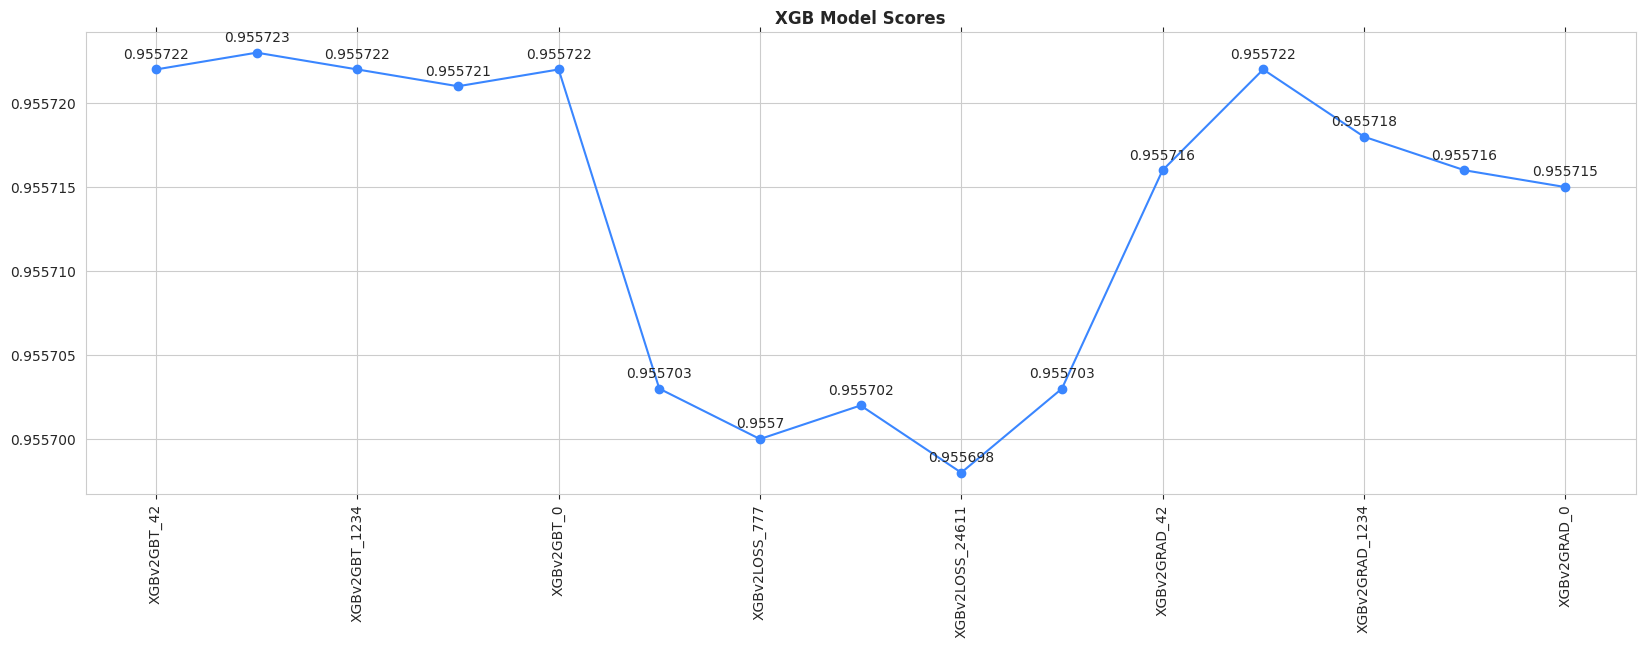

In [33]:
## -- Get Scores --
all_model_scores = {}

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            # print(k, y)
            all_model_scores[k] = y


plt.figure(figsize=(20, 6))
pd.Series(all_model_scores).plot(marker='o')
plt.title('XGB Model Scores', fontweight='semibold')
for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+1e-6, score, ha='center', va='center_baseline')

plt.tick_params('x', rotation=90, reset=True)
plt.show()

In [34]:
## -- Get oof outputs --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

XGBv2GBT_42_955722  XGBv2GBT_777_955723  XGBv2GBT_1234_955722  \
0            0.998095             0.998058              0.998071   
1            0.008587             0.008391              0.008579   
2            0.009209             0.008884              0.008878   
3            0.050982             0.052156              0.052047   
4            0.998202             0.998073              0.998131   

   XGBv2GBT_24611_955721  XGBv2GBT_0_955722  XGBv2LOSS_4_42_955703  \
0               0.998058           0.997969               0.997447   
1               0.008716           0.008639               0.008562   
2               0.009241           0.008859               0.008845   
3               0.052892           0.052449               0.048210   
4               0.998098           0.998118               0.997173   

   XGBv2LOSS_777_9557  XGBv2LOSS_1234_955702  XGBv2LOSS_24611_955698  \
0            0.997515               0.997554                0.997457   
1            0.008752               0.008889                0.008737   
2            0.008874               0.008961                0.008922   
3            0.049421               0.046721                0.048953   
4            0.997416               0.997363                0.997242   

   XGBv2LOSS_0_955703  XGBv2GRAD_42_955716  XGBv2GRAD_777_955722  \
0            0.997463             0.998178              0.998202   
1            0.008646             0.008929              0.008911   
2            0.009047             0.009298              0.009308   
3            0.048478             0.051389              0.050180   
4            0.997443             0.998044              0.998174   

   XGBv2GRAD_1234_955718  XGBv2GRAD_24611_955716  XGBv2GRAD_0_955715  
0               0.998220                0.998164            0.998166  
1               0.008820                0.008613            0.008780  
2               0.009102                0.009107            0.009270  
3               0.050725                0.050909            0.049493  
4               0.998159                0.998244            0.998164

In [35]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

XGBv2GBT_42_955722  XGBv2GBT_777_955723  XGBv2GBT_1234_955722  \
0            0.946030             0.945399              0.945593   
1            0.007467             0.007398              0.007464   
2            0.992227             0.992181              0.992131   
3            0.003499             0.003491              0.003537   
4            0.206568             0.208035              0.206472   

   XGBv2GBT_24611_955721  XGBv2GBT_0_955722  XGBv2LOSS_4_42_955703  \
0               0.945698           0.946118               0.945648   
1               0.007396           0.007453               0.007733   
2               0.992159           0.992163               0.991619   
3               0.003514           0.003495               0.003760   
4               0.207837           0.208879               0.211229   

   XGBv2LOSS_777_9557  XGBv2LOSS_1234_955702  XGBv2LOSS_24611_955698  \
0            0.945180               0.945547                0.944772   
1            0.007737               0.007611                0.007659   
2            0.991660               0.991931                0.991603   
3            0.003769               0.003797                0.003774   
4            0.210088               0.206773                0.208884   

   XGBv2LOSS_0_955703  XGBv2GRAD_42_955716  XGBv2GRAD_777_955722  \
0            0.946200             0.945510              0.944874   
1            0.007798             0.007652              0.007632   
2            0.991618             0.992382              0.992400   
3            0.003782             0.003539              0.003506   
4            0.211246             0.207728              0.207115   

   XGBv2GRAD_1234_955718  XGBv2GRAD_24611_955716  XGBv2GRAD_0_955715  
0               0.944839                0.945597            0.945183  
1               0.007645                0.007629            0.007678  
2               0.992460                0.992503            0.992610  
3               0.003592                0.003558            0.003526  
4               0.207307                0.206353            0.205516

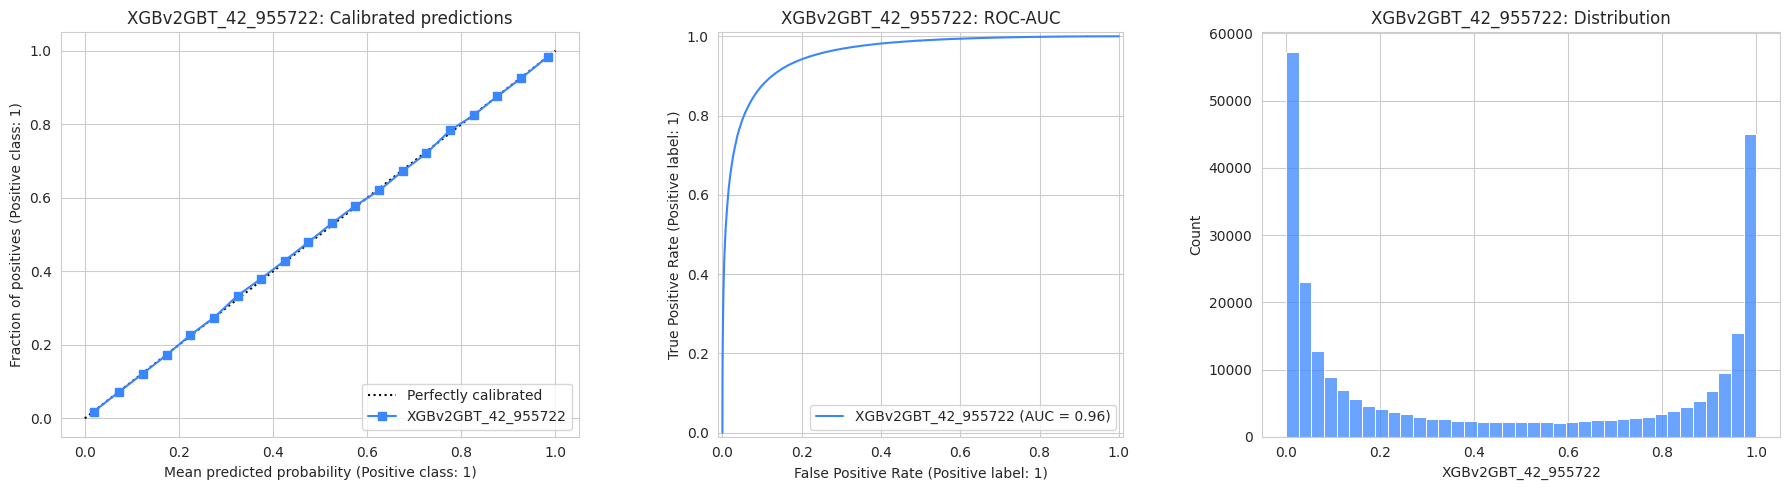

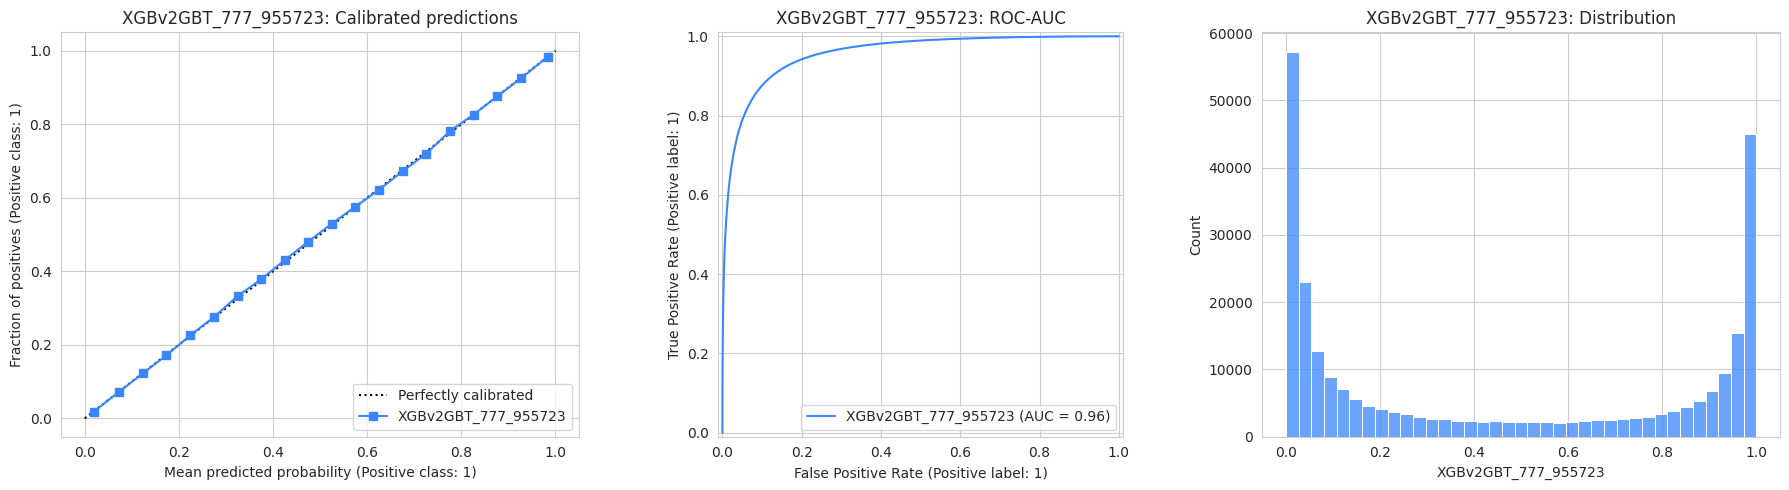

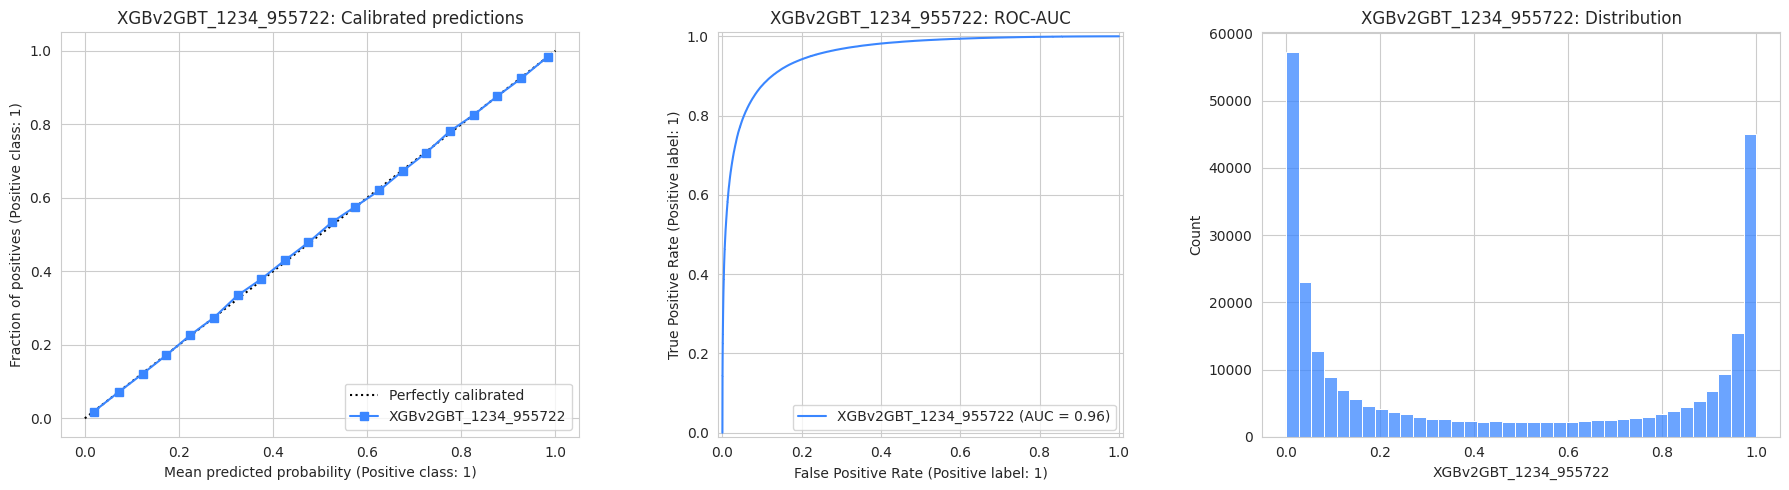

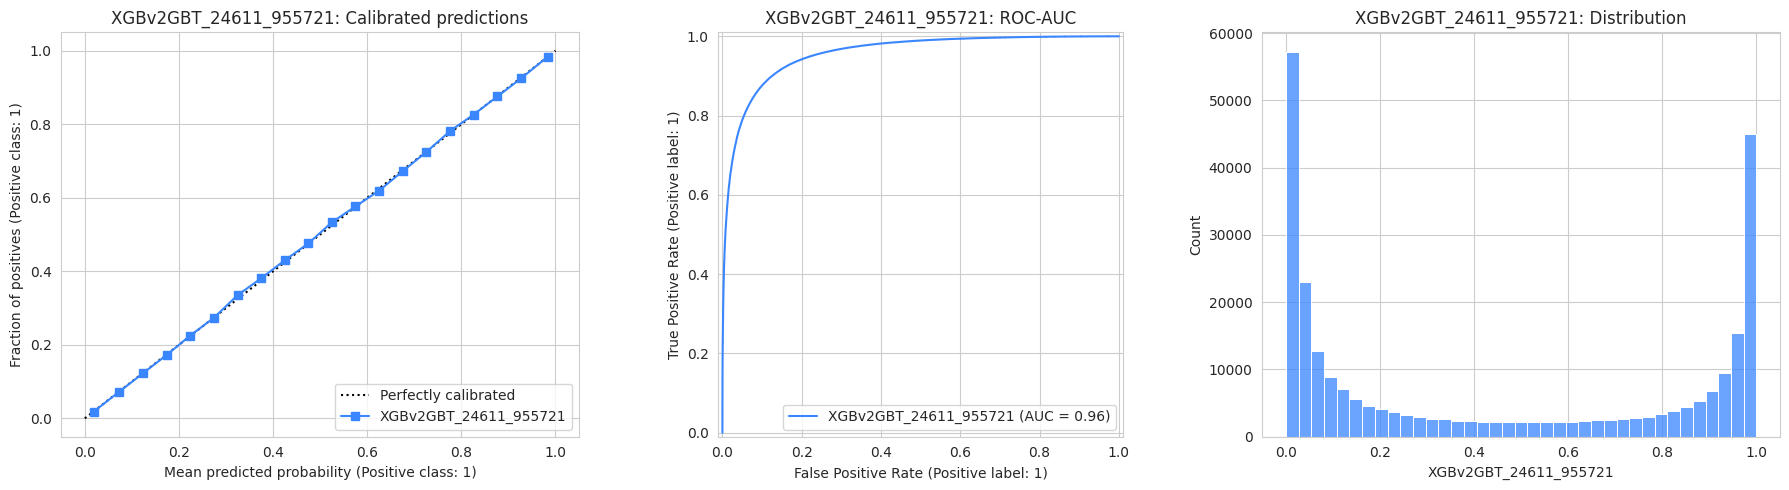

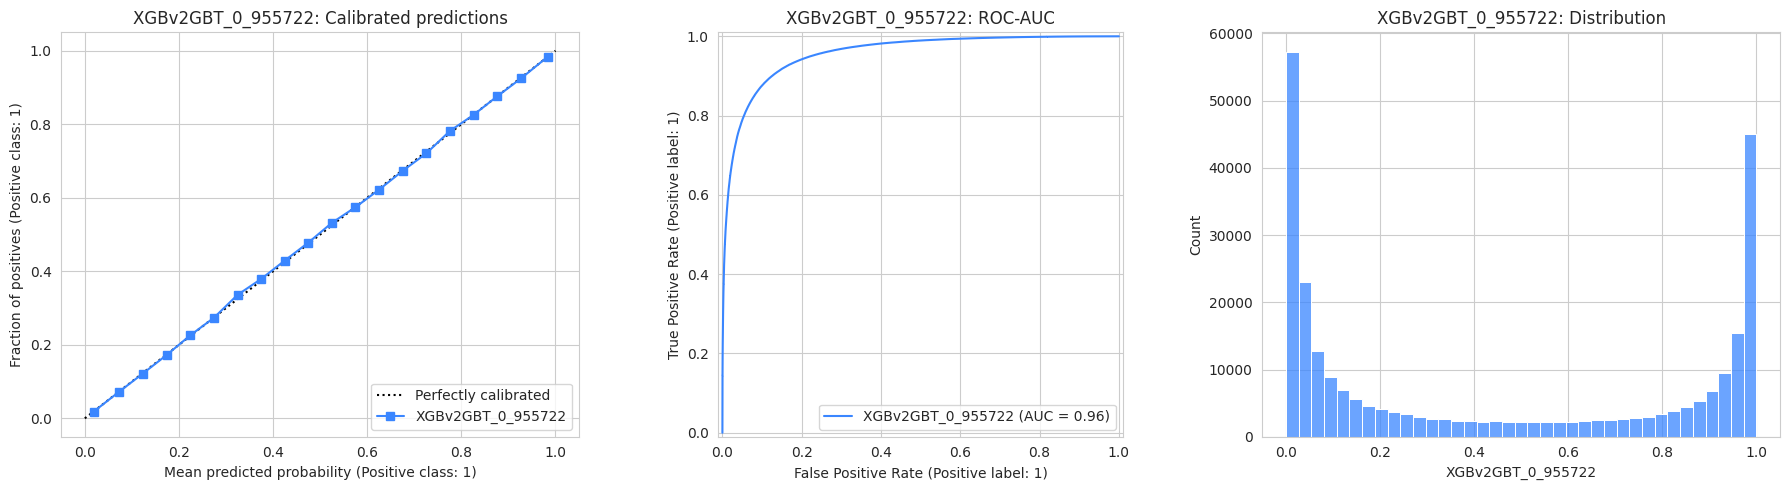

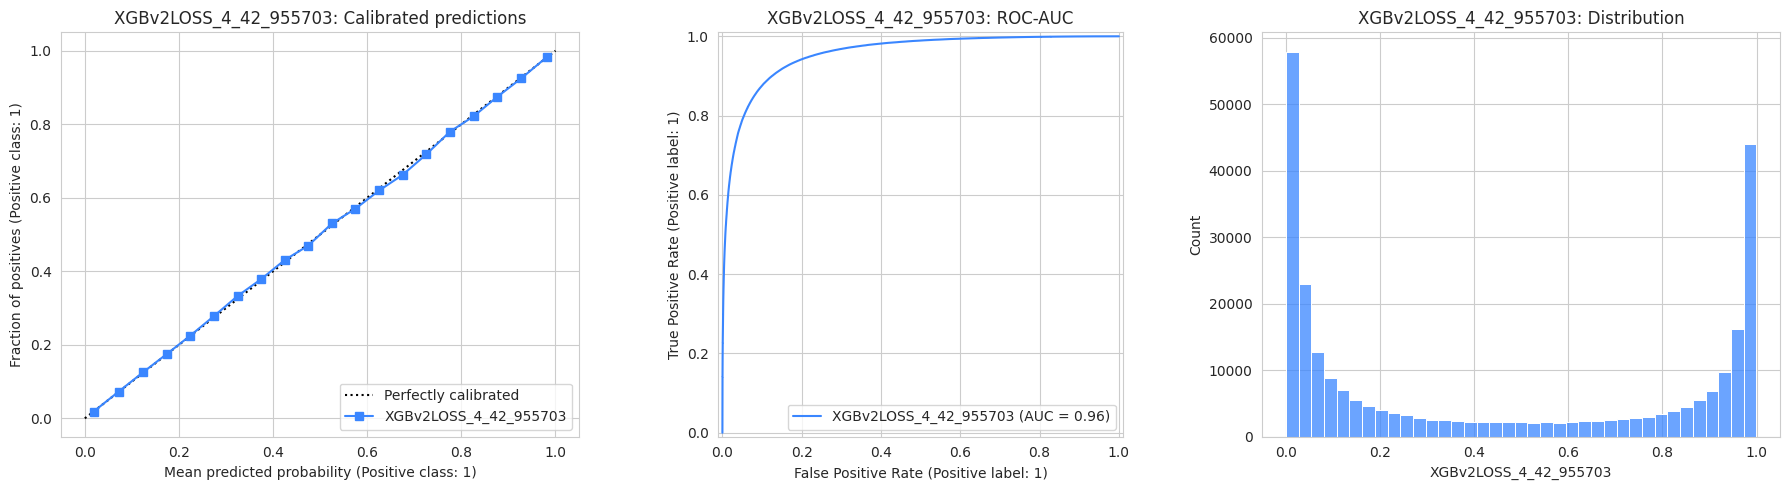

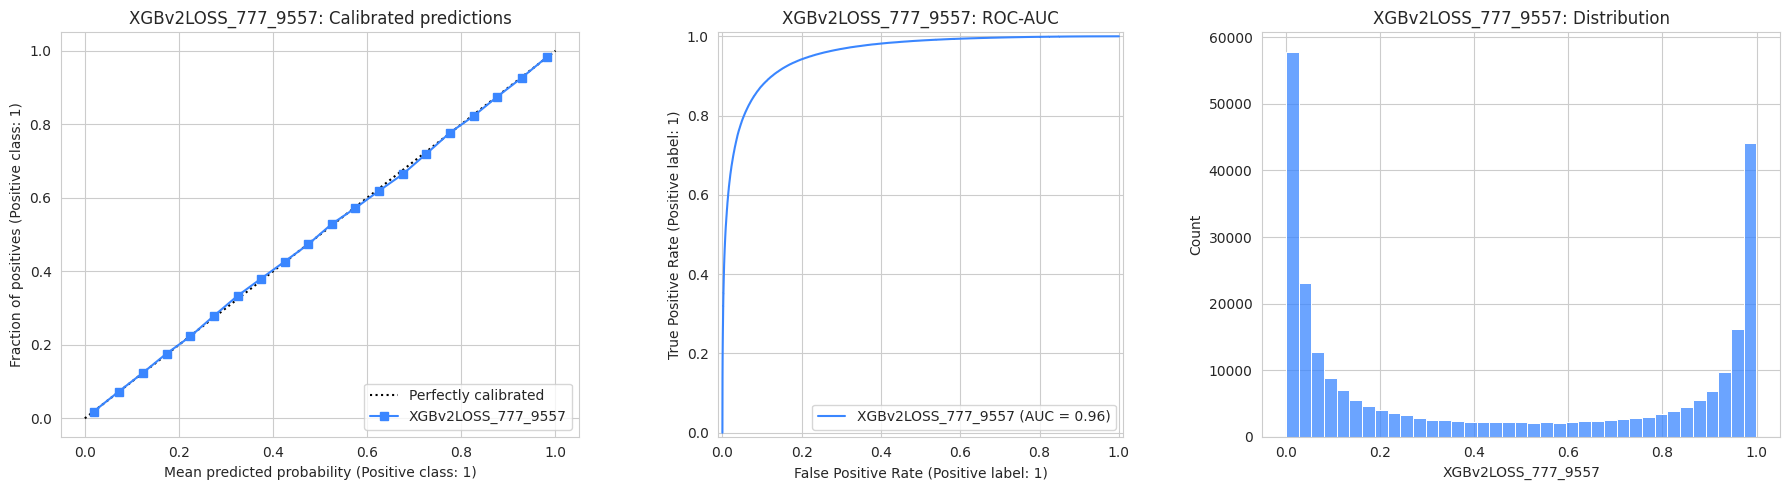

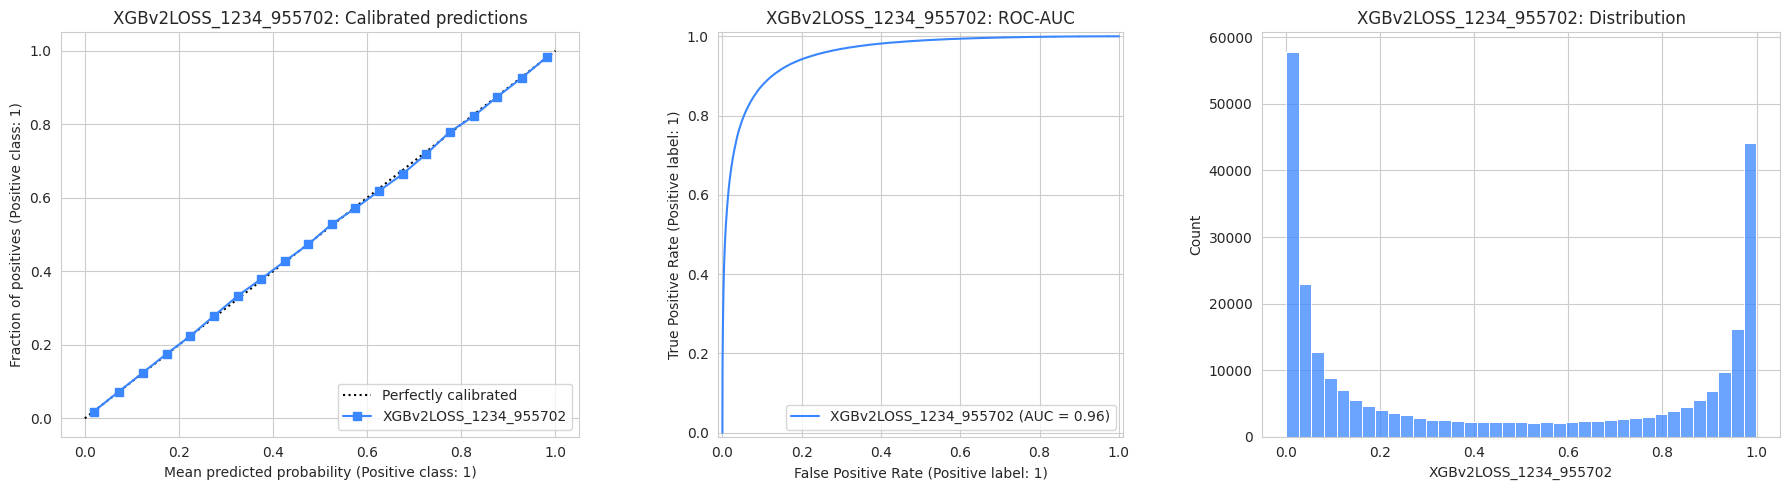

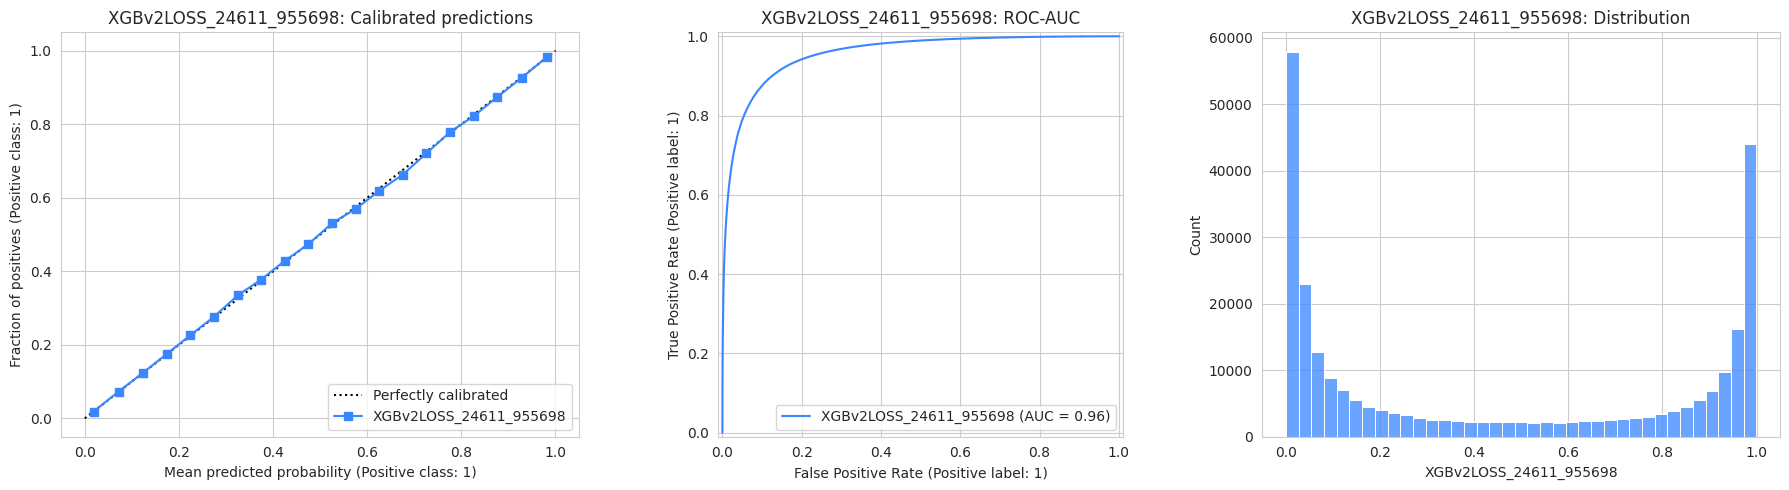

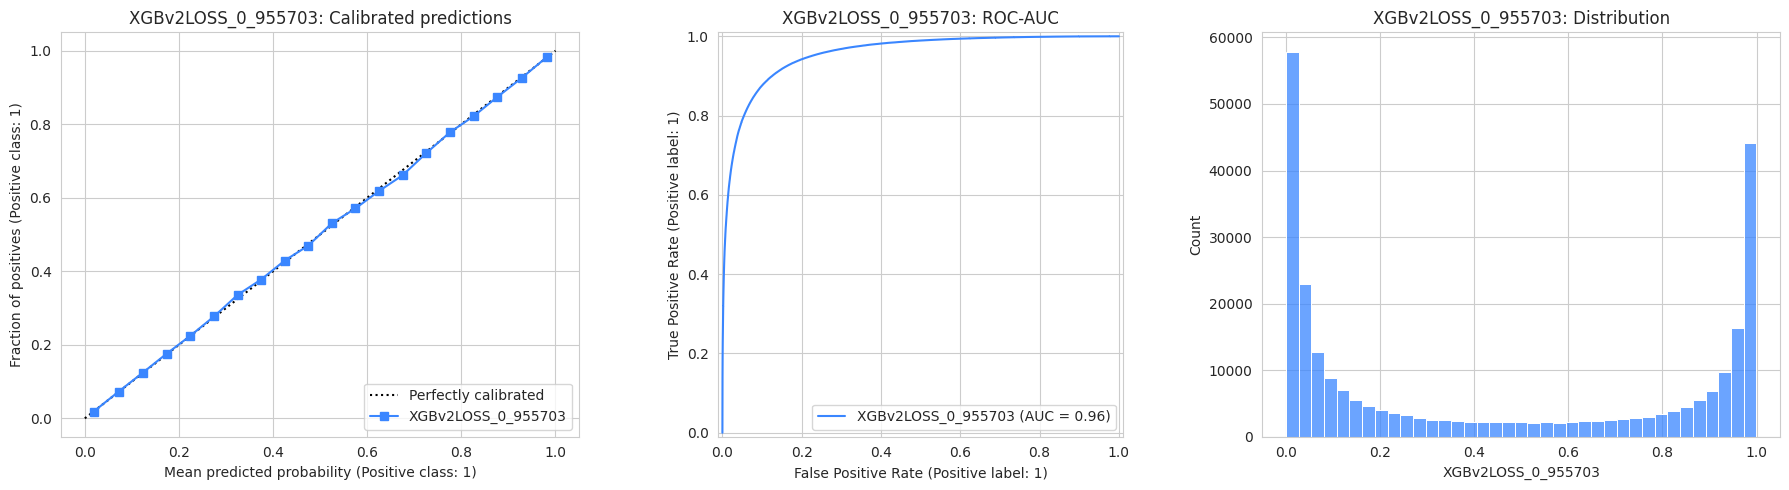

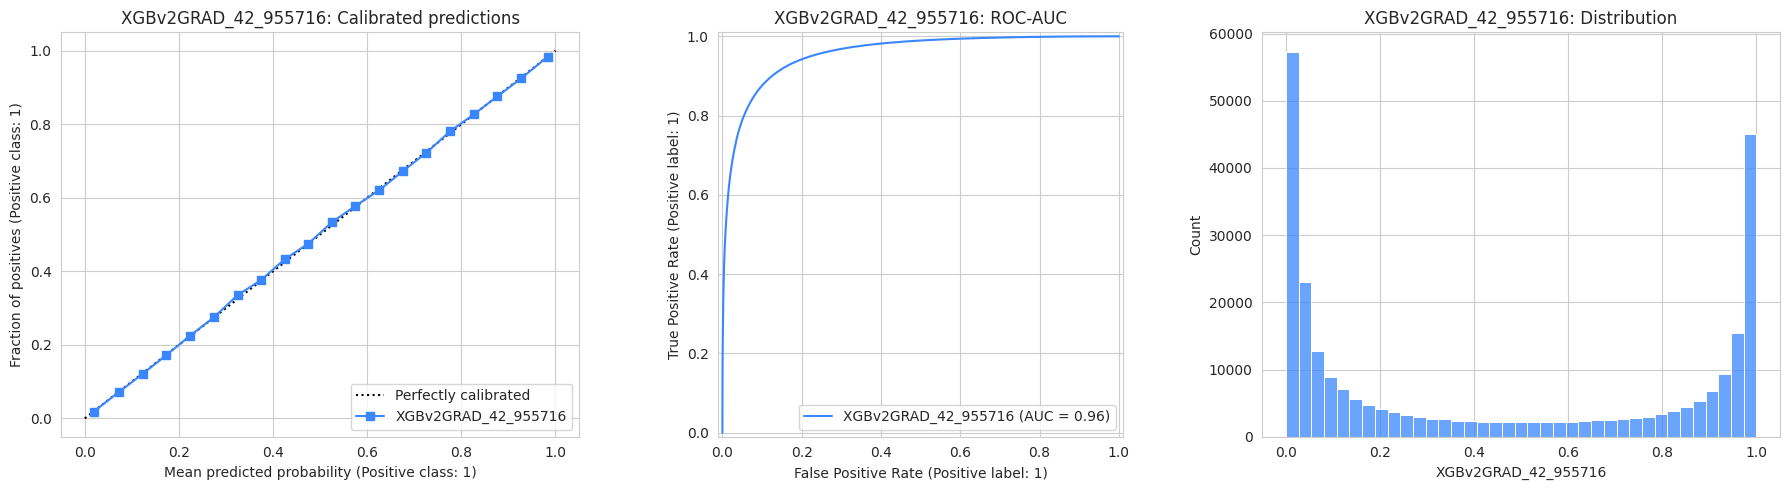

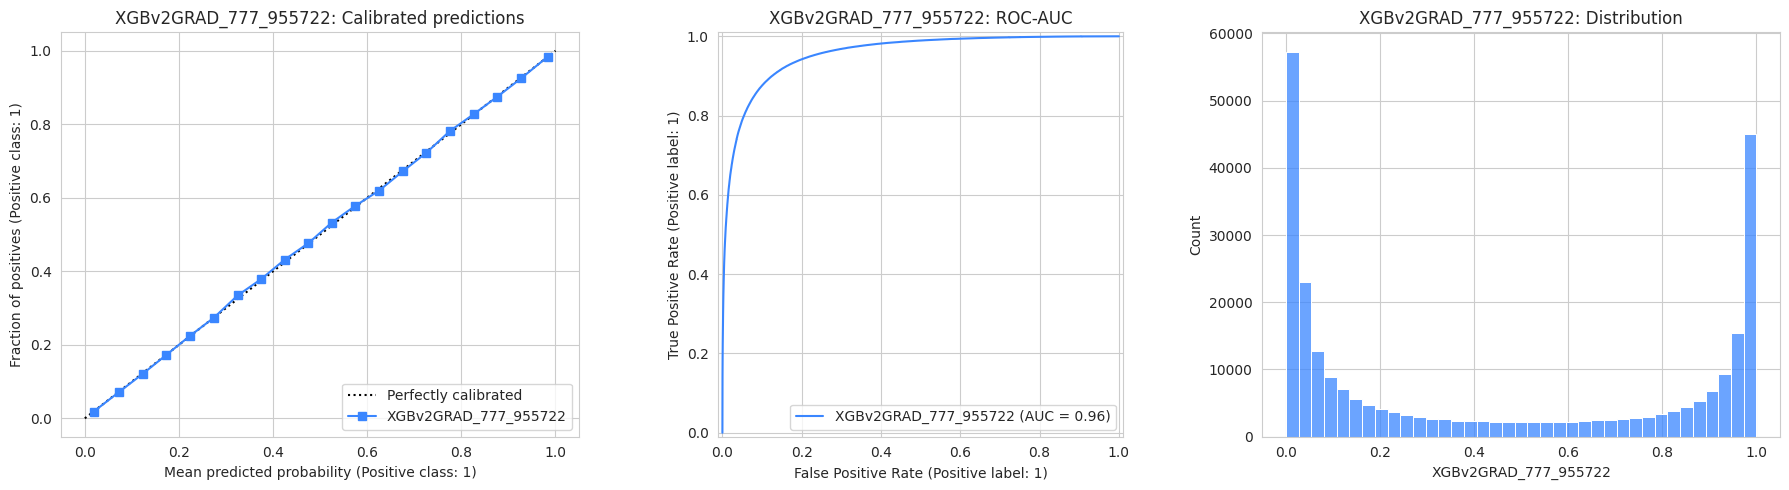

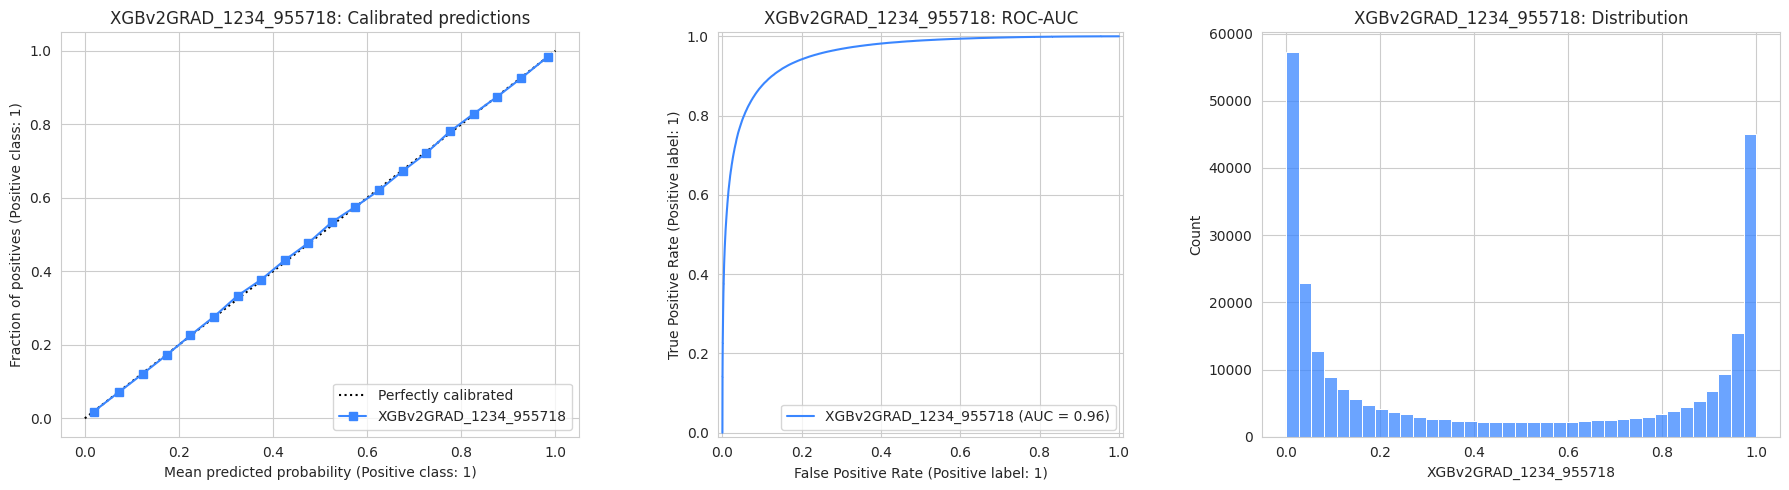

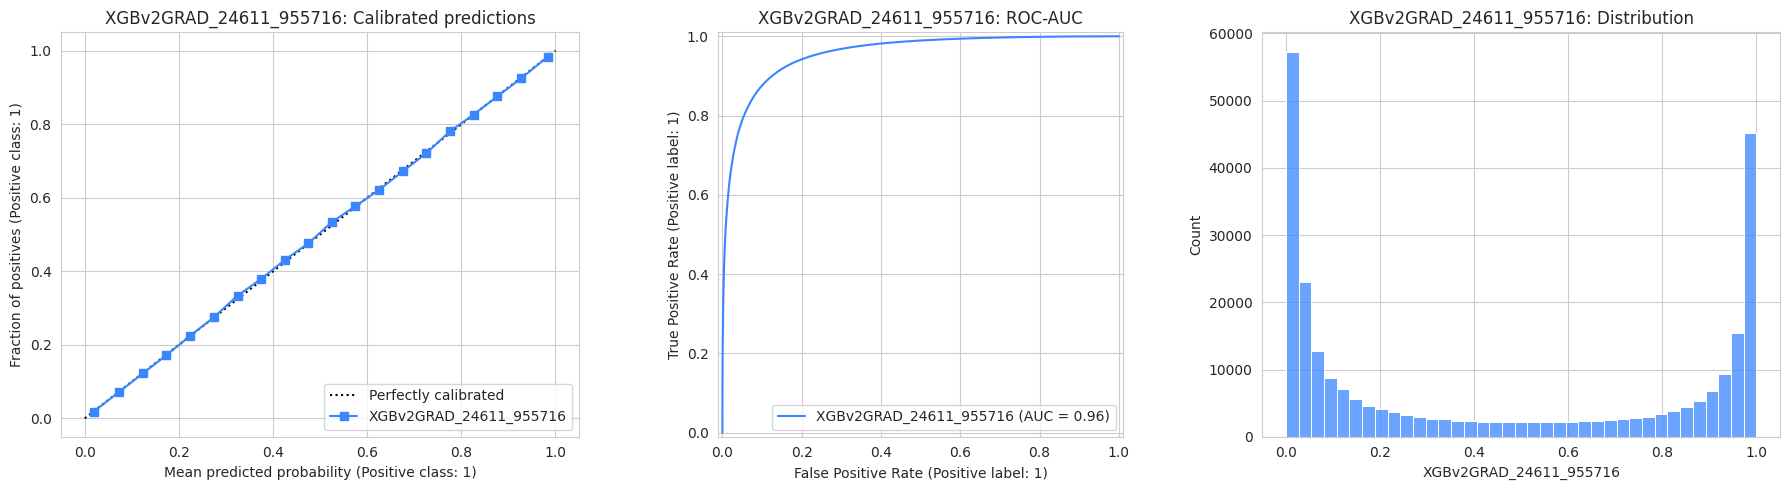

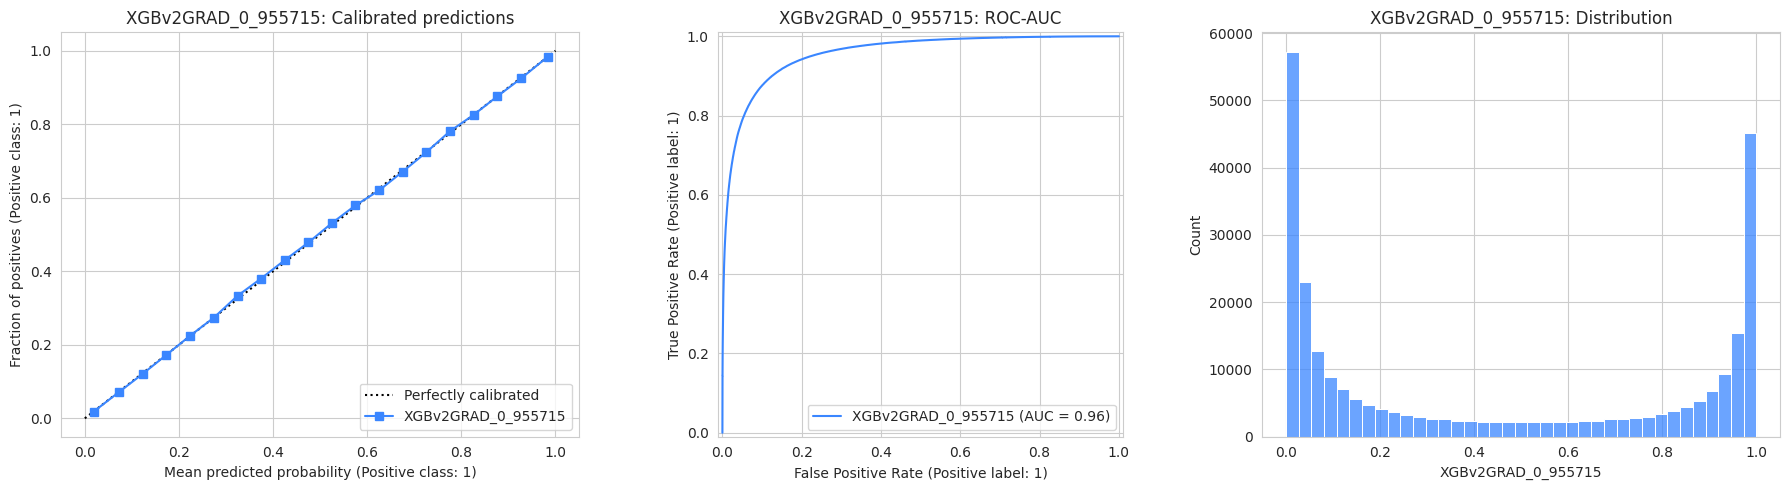

In [36]:
## -- PLOT MODEL PREDICTIONS --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    
    CalibrationDisplay.from_predictions(train[TARGET], all_model_oof[n], n_bins=20, name=n, ax=axs[0])
    axs[0].set_title(f"{n}: Calibrated predictions")
    
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")
    
    plt.tight_layout()
    plt.show()
    print()

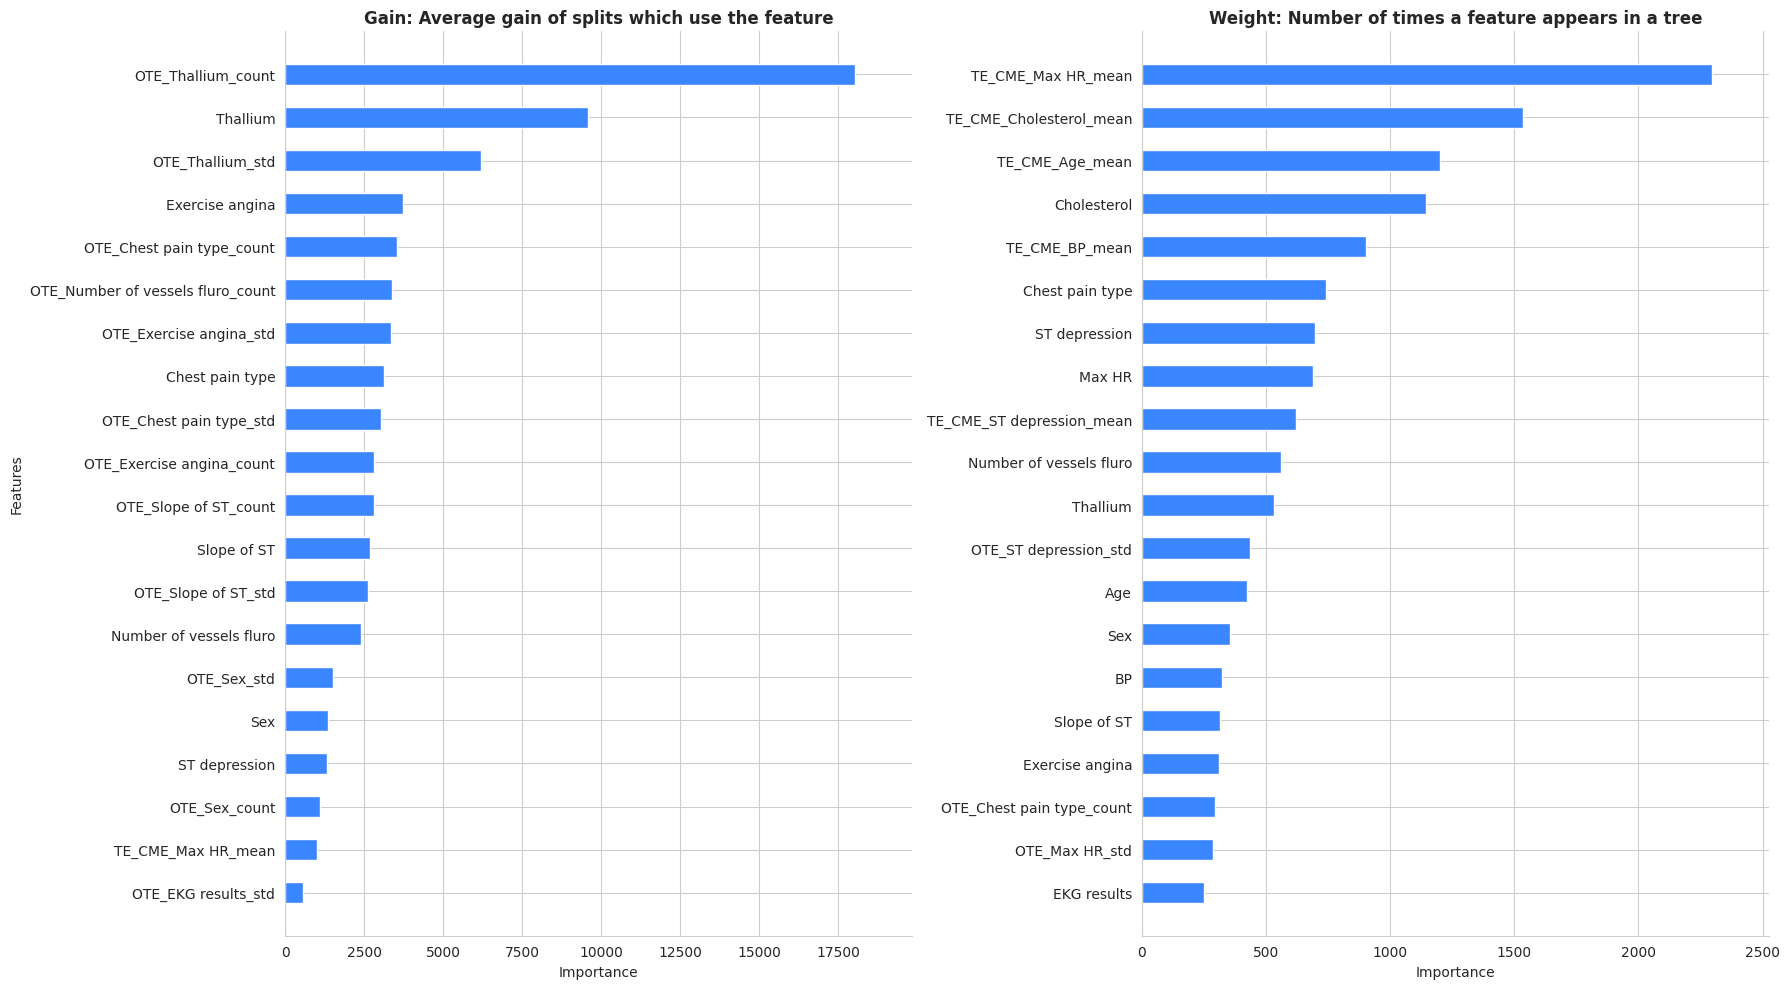

In [37]:
## -- Plot Feature Importances --
get_model = all_model_predictions[list(all_model_predictions.keys())[0]]

MAX = 20
_, axs = plt.subplots(1, 2, figsize=(18, 10))
xgb.plot_importance(
    get_model['model'],
    importance_type='gain',
    max_num_features=MAX,
    ax=axs[0], height=0.5, #grid=False,
    show_values=False,
)
axs[0].set_title('Gain: Average gain of splits which use the feature', fontweight='bold')

xgb.plot_importance(
    get_model['model'],
    importance_type='weight',
    max_num_features=MAX,
    ax=axs[1], height=0.5, #grid=False,
    show_values=False,
)
axs[1].set_title('Weight: Number of times a feature appears in a tree', fontweight='bold')
axs[1].set_ylabel('')

for ax in axs:
    ax.set_xlabel('Importance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()